# Analysis of crosslinking experiment

## Sanity Check

In [1]:
#importing usefull library
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt 
import scipy.cluster.hierarchy as sch
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
from scripts import utilities
import seaborn as sns
import gc
import os
from tqdm import tqdm_notebook as tqdm
import itertools
from scipy import stats

In [2]:
for exp in ['exp1', 'exp2', 'exp3']:
    proteinGroups = pd.read_csv(os.path.join('in_data',exp,'proteinGroups.txt'), sep='\t')   
    proteinGroups = utilities.clean(proteinGroups)
    proteinGroups['prot_id']=[utilities.clean_id(n) for n in proteinGroups['Protein IDs']]
    proteinGroups.set_index('prot_id',inplace=True)
    print(proteinGroups.shape)
    proteinGroups.to_csv(os.path.join('in_data' ,exp, exp+'.csv'))
    for label,name in zip(['LFQ intensity ','MS/MS Count ', 'iBAQ ', 'Unique peptides '],['lfq','msms','ibaq','upep']):
        temp = utilities.get_data(proteinGroups, label,  '', list(np.arange(1,28,1)))
        temp.to_csv(os.path.join('in_data' ,exp, name+'.csv')) 

d:\my_env\prediction\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (292,293) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


removed  93 Only identified by site
tot  93  entries removed
---------------
removed  47 Reverse
tot  140  entries removed
---------------
removed  55 Potential contaminant
tot  195  entries removed
---------------
removed  414 Peptide counts (unique)
tot  609  entries removed
---------------
(4294, 306)
got:  4294 protein now
got:  4294 protein now
got:  4294 protein now
got:  4294 protein now


d:\my_env\prediction\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (292,293) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


removed  96 Only identified by site
tot  96  entries removed
---------------
removed  47 Reverse
tot  143  entries removed
---------------
removed  63 Potential contaminant
tot  206  entries removed
---------------
removed  385 Peptide counts (unique)
tot  591  entries removed
---------------
(4289, 306)
got:  4289 protein now
got:  4289 protein now
got:  4289 protein now
got:  4289 protein now
removed  69 Only identified by site
tot  69  entries removed
---------------
removed  44 Reverse
tot  113  entries removed
---------------
removed  44 Potential contaminant
tot  157  entries removed
---------------
removed  436 Peptide counts (unique)
tot  593  entries removed
---------------
(4016, 306)
got:  4016 protein now
got:  4016 protein now
got:  4016 protein now
got:  4016 protein now


In [2]:
def get_exp(label=''):
    exp_list = []
    for exp in ['exp1', 'exp2', 'exp3']:
        fpath = os.path.join('in_data', exp, label+'.csv')
        df = pd.read_csv(fpath)
        df = df.drop_duplicates('prot_id')
        df = df.set_index('prot_id')
        df['max'] = np.argmax(df.values,axis=1)
        df = df[(df['max']>2)]#'' & (df['max']<18)]
        del df['max']
        exp_list.append(df)
    return exp_list

def only_unique(exp_list):
    prots = set(exp_list[0].index.values)
    for n in exp_list[1:]:
        prots  = prots & set(n.index.values)
    exp_list = [n.loc[prots] for n in exp_list]
    return exp_list

def get_corr(exp_list):    
    rows = exp_list[0].index.values
    indexes = np.arange(len(exp_list))
    pairs = [n for n in itertools.combinations(indexes,2)]
    res = {}
    for n in pairs:
        key = str(n[0])+'_'+str(n[1])
        print(key)
        res[key]=[]
    for row in rows:
        for n in pairs:
            key = str(n[0])+'_'+str(n[1])
            #print(exp_list[n[0]].loc[prot].values)
            pearson,pval = stats.pearsonr(exp_list[n[0]].loc[row].values,
                           exp_list[n[1]].loc[row].values)
            res[key]+=[pearson]
    for n in pairs:
        key = str(n[0])+'_'+str(n[1])
        res[key]=pd.Series(res[key])
    return res

In [18]:
res = {}
for label in ['lfq', 'ibaq','msms', 'upep']:
    exp_list = get_exp(label=label)
    exp_list = only_unique(exp_list)
    corr_prots = get_corr(exp_list)
    corr_columns = get_corr([n.T for n in exp_list])
    res[label]=[exp_list, corr_prots, corr_columns]   

0_1
0_2
1_2
0_1
0_2
1_2
0_1
0_2
1_2
0_1
0_2
1_2
0_1
0_2
1_2
0_1
0_2
1_2
0_1
0_2
1_2
0_1
0_2
1_2


In [4]:
def make_corr_plot(corr_prots, corr_columns, suptitle):
    fig, axes=plt.subplots(figsize=(21,6),ncols=3,nrows=1)
    corr_prots['0_1'].plot(kind='hist',ax=axes[0],label='EXP 1 2',histtype=u'step',linewidth=2)
    corr_prots['0_2'].plot(kind='hist',ax=axes[0],label='EXP 1 3',histtype=u'step',linewidth=2)
    corr_prots['1_2'].plot(kind='hist',ax=axes[0],label='EXP 2 3',histtype=u'step',linewidth=2)
    axes[0].set_title('Histogram')
    axes[0].set_xlabel('Pearson')
    axes[0].set_ylabel('Pair Count')

    axes[0].legend(loc=2)

    data = pd.concat([corr_prots['0_1'],corr_prots['0_2'],corr_prots['1_2']])
    data = data.to_frame()
    data.columns=['Pearson']
    label_1 = ['EXP 1 2' for n in range(corr_prots['0_1'].shape[0])]
    label_2 = ['EXP 1 3' for n in range(corr_prots['0_2'].shape[0])]
    label_3 = ['EXP 2 3' for n in range(corr_prots['1_2'].shape[0])] 
    data['Pair']=label_1+label_2+label_3
    sns.boxplot(x="Pair", y="Pearson", data=data,ax=axes[1])
    axes[1].set_title('Box Plot')
    for l in ['EXP 1 2','EXP 1 3','EXP 2 3']:
        print('mean '+l,data[data['Pair']==l].mean())
        print('median '+l,data[data['Pair']==l].median())
    
    data = pd.DataFrame()
    data['EXP 1 2']=corr_columns['0_1'].values
    data['EXP 1 3']=corr_columns['0_2'].values
    data['EXP 2 3']=corr_columns['1_2'].values
    axes[2].set_title('Line')
    axes[2].set_xlabel('Fraction')
    axes[2].set_ylabel('Pearson Correlation')
    data.plot(ax=axes[2])
    #axes[2].set_ylim(0,1)
    plt.suptitle(suptitle)
    plt.show()

mean EXP 1 2 Pearson    0.530549
dtype: float64
median EXP 1 2 Pearson    0.656584
dtype: float64
mean EXP 1 3 Pearson    0.577147
dtype: float64
median EXP 1 3 Pearson    0.704692
dtype: float64
mean EXP 2 3 Pearson    0.550465
dtype: float64
median EXP 2 3 Pearson    0.686735
dtype: float64


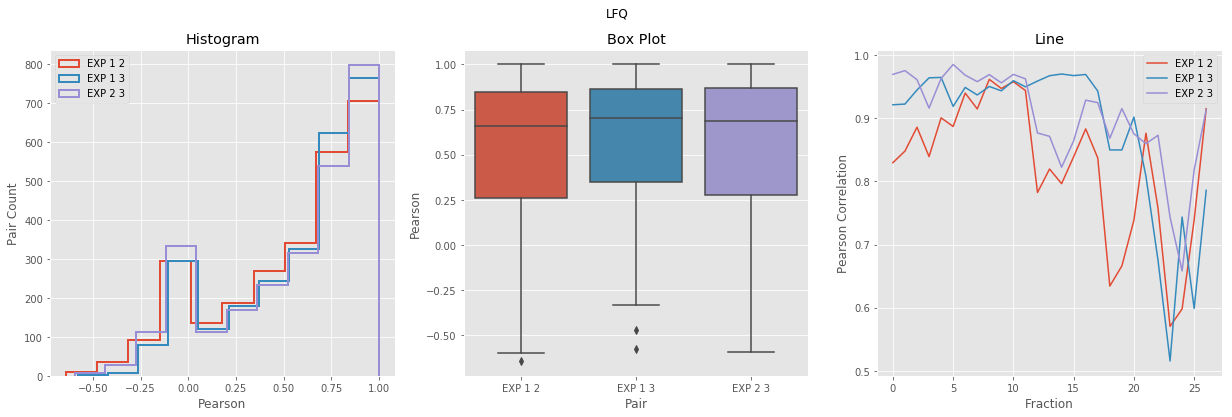

In [5]:
plt.style.use('ggplot')
make_corr_plot(res['lfq'][1], res['lfq'][2], suptitle='LFQ')

mean EXP 1 2 Pearson    0.382524
dtype: float64
median EXP 1 2 Pearson    0.418414
dtype: float64
mean EXP 1 3 Pearson    0.660227
dtype: float64
median EXP 1 3 Pearson    0.733515
dtype: float64
mean EXP 2 3 Pearson    0.53024
dtype: float64
median EXP 2 3 Pearson    0.605394
dtype: float64


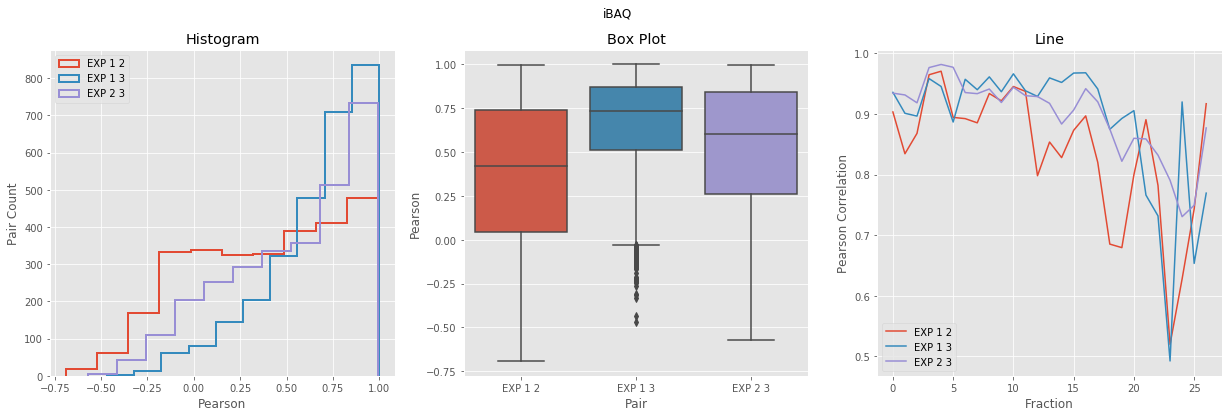

In [6]:
plt.style.use('ggplot')
make_corr_plot(res['ibaq'][1], res['ibaq'][2], suptitle='iBAQ')

mean EXP 1 2 Pearson    0.535075
dtype: float64
median EXP 1 2 Pearson    0.603195
dtype: float64
mean EXP 1 3 Pearson    0.619958
dtype: float64
median EXP 1 3 Pearson    0.685661
dtype: float64
mean EXP 2 3 Pearson    0.556291
dtype: float64
median EXP 2 3 Pearson    0.62782
dtype: float64


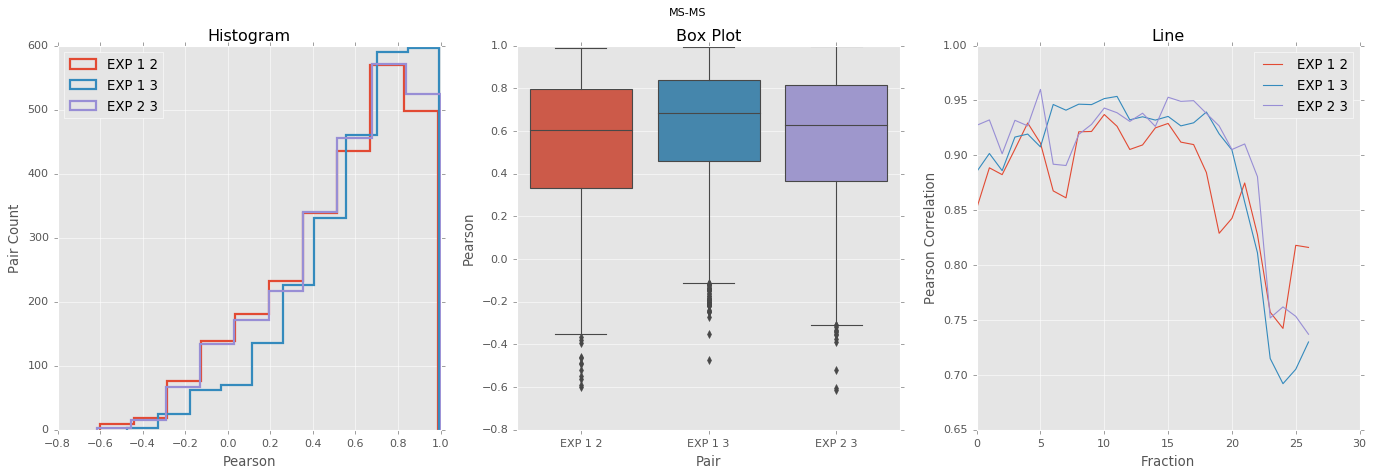

In [19]:
plt.style.use('ggplot')
make_corr_plot(res['msms'][1], res['msms'][2], suptitle='MS-MS')

mean EXP 1 2 Pearson    0.569089
dtype: float64
median EXP 1 2 Pearson    0.675611
dtype: float64
mean EXP 1 3 Pearson    0.687147
dtype: float64
median EXP 1 3 Pearson    0.767507
dtype: float64
mean EXP 2 3 Pearson    0.591401
dtype: float64
median EXP 2 3 Pearson    0.69649
dtype: float64


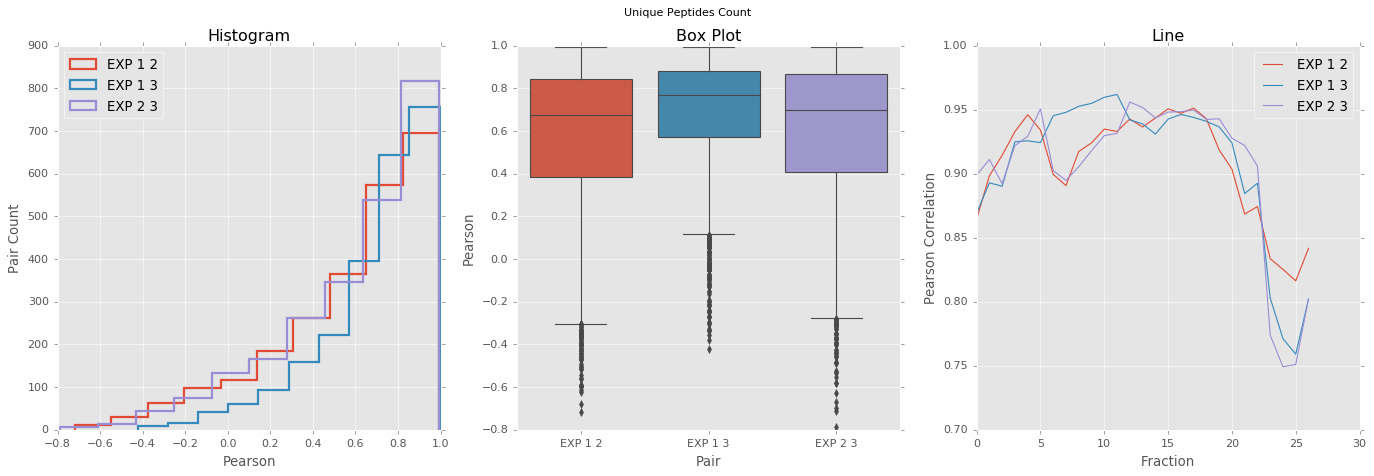

In [20]:
plt.style.use('ggplot')
make_corr_plot(res['upep'][1], res['upep'][2], suptitle='Unique Peptides Count')

In [10]:
from scripts import make_fig
from scripts import utilities

In [21]:
#temp.shape

                LFQ intensity 1  LFQ intensity 2  LFQ intensity 3  \
prot_id                                                             
Tb927.11.15120          8868700          8511600          8742400   
Tb927.10.650                  0                0                0   
Tb927.6.3800         4927700000       6104300000       6501900000   
Tb11.v5.0480                  0                0                0   
Tb927.11.15280                0                0                0   

                LFQ intensity 4  LFQ intensity 5  LFQ intensity 6  \
prot_id                                                             
Tb927.11.15120         15113000          9805400         20218000   
Tb927.10.650                  0                0                0   
Tb927.6.3800         6087400000       5110600000       4541900000   
Tb11.v5.0480           17710000         27323000         19920000   
Tb927.11.15280                0                0                0   

                LFQ intensity 7 

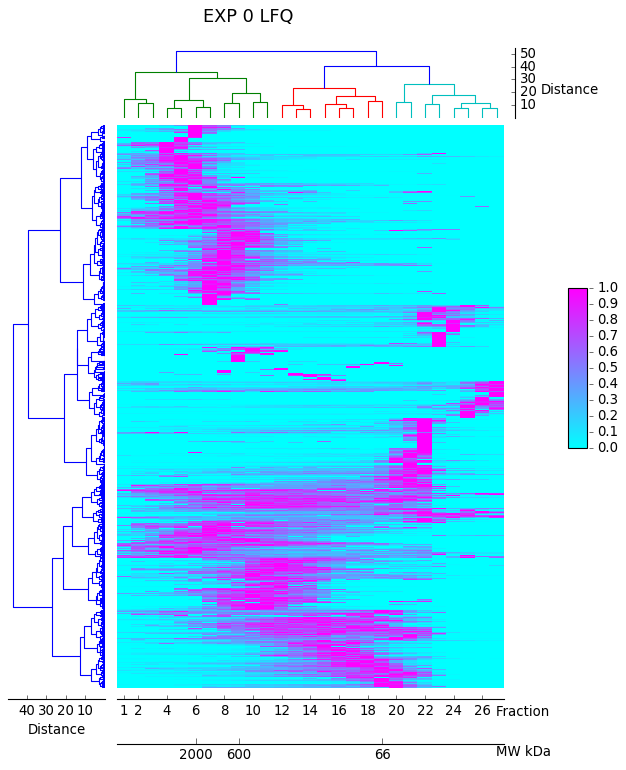

In [15]:
import warnings
warnings.filterwarnings("ignore")
#create the plot
temp = res['lfq'][0][0]
#temp[temp<3]=0
#temp = temp[(temp.T != 0).any()]
print (temp.head())
cluster_df, leaves = make_fig.plot_experiment(
     temp.apply(utilities.norm_max,1),
     method='ward', 
     metric='euclidean',
     cluster_columns = True,
     order_row_and_columns= False,
     color_map_id='cool',
     figsize=(8, 10),
     cut_distance_cols=40,
     cut_distance_rows=0.1,
     step_first_x = 2,
     title='EXP 0 LFQ',
     fig_name = 'EXP 0 LFQ.png',
     add_second_axis={'label':'MW kDa',
                      'values': {
                      6:'2000', 
                      9:'600', 
                      #4:'132', 
                      19:'66', 
                      } 
                      },
    height_ratios=[1, 8],
    hspace=0.02,
    get_clusters=True,
    owerwrite_order=False,
     )


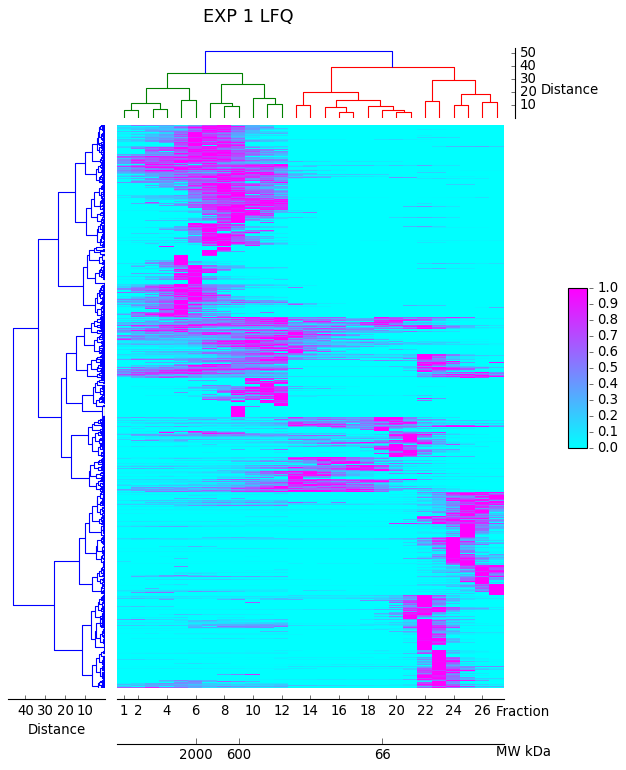

In [13]:
import warnings
warnings.filterwarnings("ignore")
#create the plot
cluster_df, leaves = make_fig.plot_experiment(
     res['lfq'][0][1].apply(utilities.norm_max,1),
     method='ward', 
     metric='euclidean',
     cluster_columns = True,
     order_row_and_columns= False,
     color_map_id='cool',
     figsize=(8, 10),
     cut_distance_cols=40,
     cut_distance_rows=0.1,
     step_first_x = 2,
     title='EXP 1 LFQ',
     fig_name = 'EXP 1 LFQ.png',
     add_second_axis={'label':'MW kDa',
                      'values': {
                      6:'2000', 
                      9:'600', 
                      #4:'132', 
                      19:'66', 
                      } 
                      },
    height_ratios=[1, 8],
    hspace=0.02,
    get_clusters=True,
    owerwrite_order=False,
     )


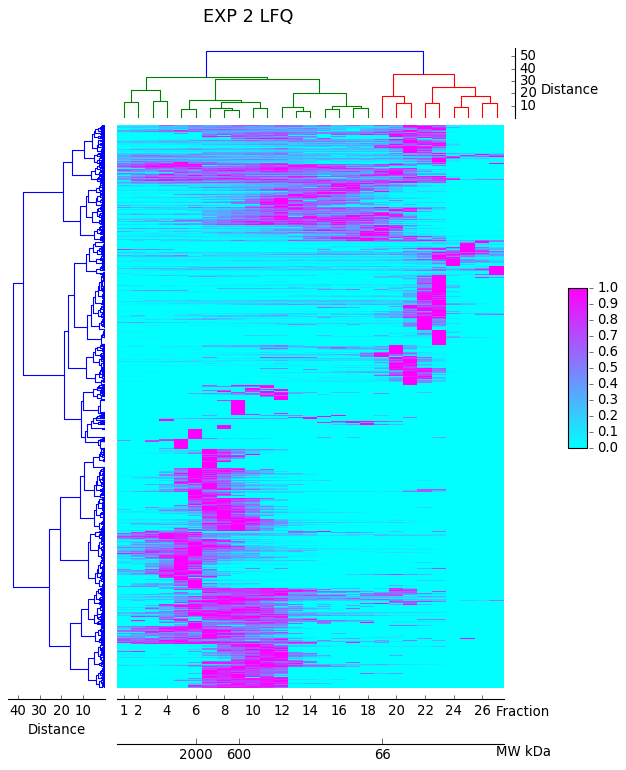

In [14]:
import warnings
warnings.filterwarnings("ignore")
#create the plot

temp = res['lfq'][0][2]
temp.head()
cluster_df, leaves = make_fig.plot_experiment(
     temp.apply(utilities.norm_max,1),
     method='ward', 
     metric='euclidean',
     cluster_columns = True,
     order_row_and_columns= False,
     color_map_id='cool',
     figsize=(8, 10),
     cut_distance_cols=40,
     cut_distance_rows=0.1,
     step_first_x = 2,
     title='EXP 2 LFQ',
     fig_name = 'EXP 2 LFQ.png',
     add_second_axis={'label':'MW kDa',
                      'values': {
                      6:'2000', 
                      9:'600', 
                      #4:'132', 
                      19:'66', 
                      } 
                      },
    height_ratios=[1, 8],
    hspace=0.02,
    get_clusters=True,
    owerwrite_order=False,
     )


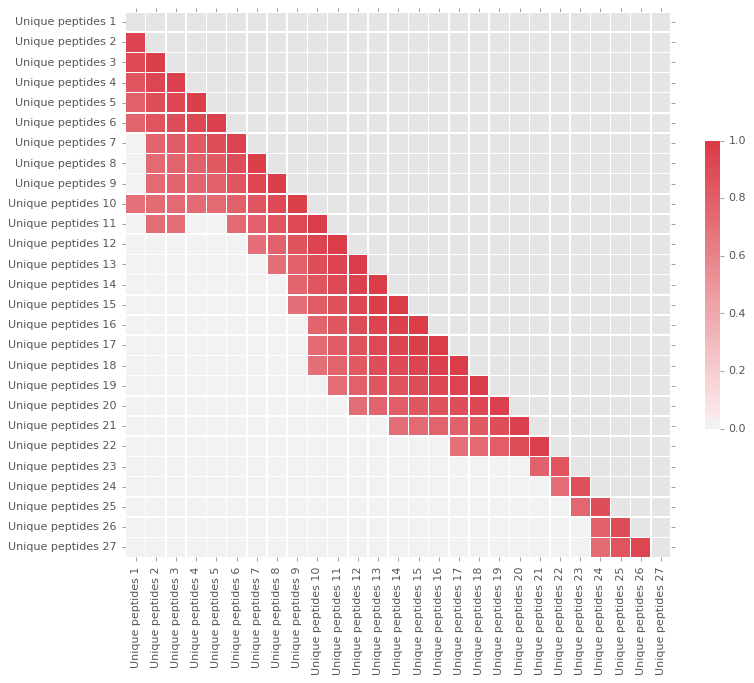

In [22]:

corr = res['upep'][0][0].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corr[corr<0.7]=0
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



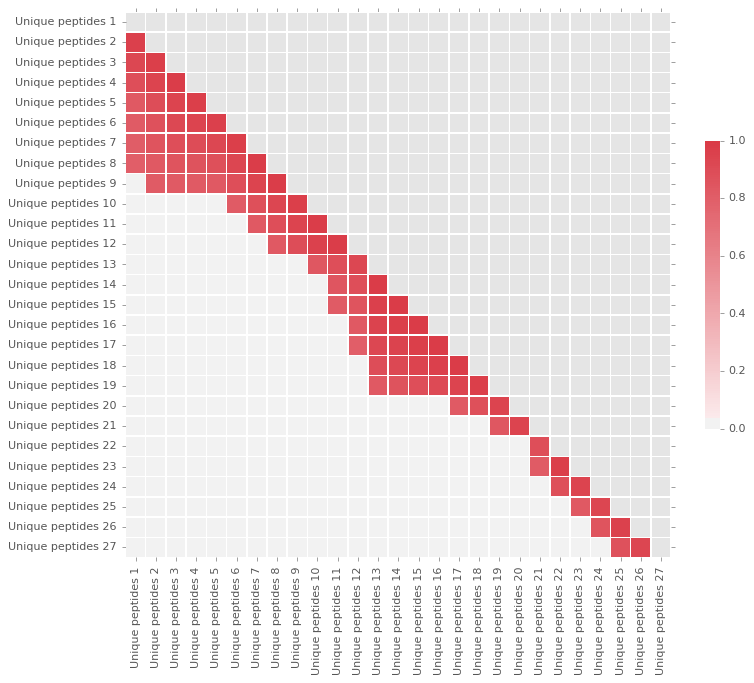

In [23]:
corr = res['upep'][0][1].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corr[corr<0.8]=0
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



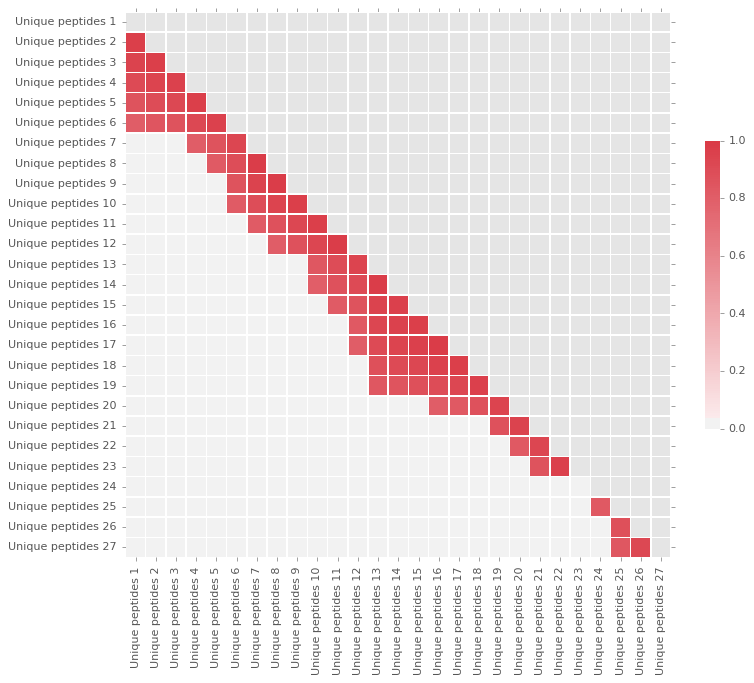

In [24]:
corr = res['upep'][0][2].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corr[corr<0.8]=0
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [761]:
for item in range(1,28):
    print (corr.loc['Unique peptides '+str(item)].sort_values(ascending=False)[:5])
    print('_____')

Unique peptides 1    1.000000
Unique peptides 2    0.971806
Unique peptides 3    0.940801
Unique peptides 4    0.920200
Unique peptides 5    0.879731
Name: Unique peptides 1, dtype: float64
_____
Unique peptides 2    1.000000
Unique peptides 1    0.971806
Unique peptides 3    0.970614
Unique peptides 4    0.955166
Unique peptides 5    0.912890
Name: Unique peptides 2, dtype: float64
_____
Unique peptides 3    1.000000
Unique peptides 2    0.970614
Unique peptides 4    0.963970
Unique peptides 1    0.940801
Unique peptides 5    0.926732
Name: Unique peptides 3, dtype: float64
_____
Unique peptides 4    1.000000
Unique peptides 5    0.970850
Unique peptides 3    0.963970
Unique peptides 2    0.955166
Unique peptides 1    0.920200
Name: Unique peptides 4, dtype: float64
_____
Unique peptides 5    1.000000
Unique peptides 4    0.970850
Unique peptides 6    0.944498
Unique peptides 3    0.926732
Unique peptides 2    0.912890
Name: Unique peptides 5, dtype: float64
_____
Unique peptides 6   

In [762]:
new_df = res['lfq'][0][1].copy()
cols = ['LFQ intensity '+str(n) for  n in range(1,13)]
cols+= ['LFQ intensity '+str(n) for  n in range(13,22)][::-1]
cols+=['LFQ intensity '+str(n) for  n in range(22,28)]
new_df.columns =cols
new_df = new_df[['LFQ intensity '+str(n) for  n in range(1,28)]]


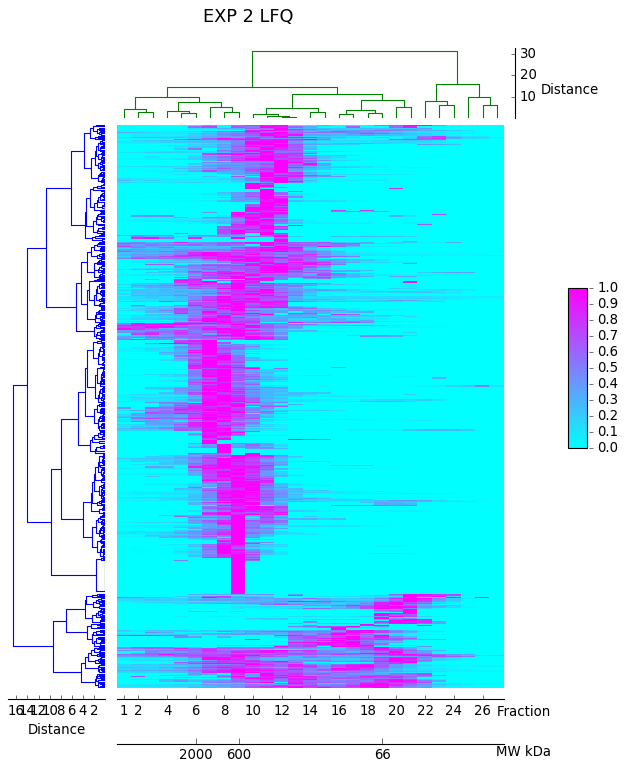

In [763]:
import warnings
warnings.filterwarnings("ignore")
#create the plot

cluster_df, leaves = make_fig.plot_experiment(
     new_df.apply(utilities.norm_max,1),
     method='ward', 
     metric='euclidean',
     cluster_columns = True,
     order_row_and_columns= False,
     color_map_id='cool',
     figsize=(8, 10),
     cut_distance_cols=40,
     cut_distance_rows=0.1,
     step_first_x = 2,
     title='EXP 2 LFQ',
     fig_name = 'EXP 2 LFQ.png',
     add_second_axis={'label':'MW kDa',
                      'values': {
                      6:'2000', 
                      9:'600', 
                      #4:'132', 
                      19:'66', 
             http://localhost:8888/notebooks/Sanity_check.ipynb#         } 
                      },
    height_ratios=[1, 8],
    hspace=0.02,
    get_clusters=True,
    owerwrite_order=False,
     )


0_1
0_2
1_2
0_1
0_2
1_2
mean EXP 1 2 Pearson    0.664602
dtype: float64
median EXP 1 2 Pearson    0.779893
dtype: float64
mean EXP 1 3 Pearson    0.721129
dtype: float64
median EXP 1 3 Pearson    0.835976
dtype: float64
mean EXP 2 3 Pearson    0.670016
dtype: float64
median EXP 2 3 Pearson    0.800303
dtype: float64


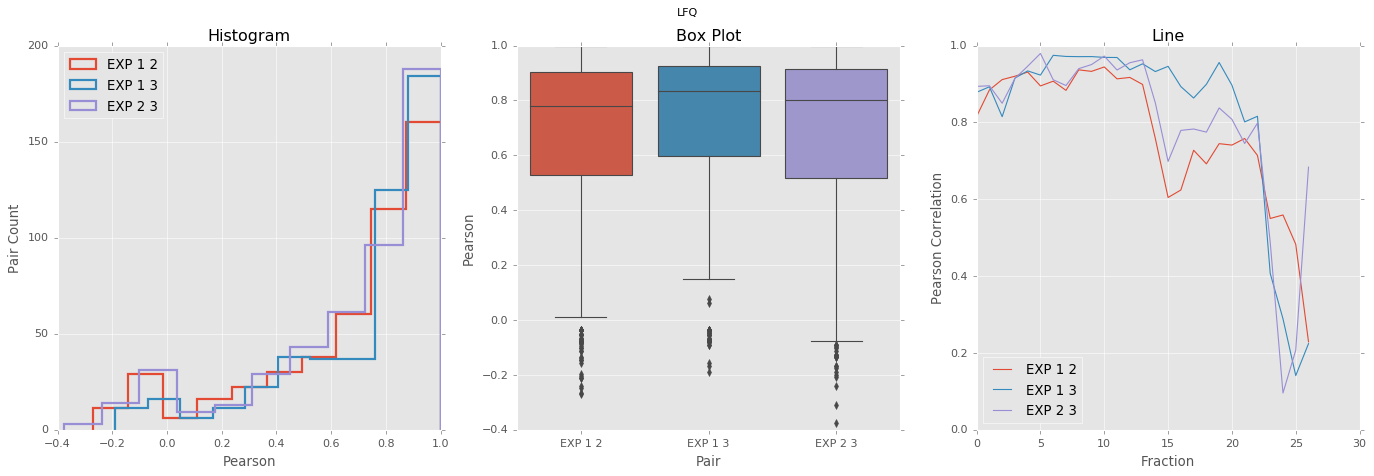

In [764]:

new_df_list = [n.copy() for n in res['lfq'][0]]
new_df_list[1] = new_df
corr_prots = get_corr(new_df_list)
corr_columns = get_corr([n.T for n in new_df_list])
res['lfq2']=[new_df_list, corr_prots, corr_columns]   

plt.style.use('ggplot')
make_corr_plot(res['lfq2'][1], res['lfq2'][2], suptitle='LFQ')

mean EXP 1 2 Pearson    0.621117
dtype: float64
median EXP 1 2 Pearson    0.716517
dtype: float64
mean EXP 1 3 Pearson    0.721129
dtype: float64
median EXP 1 3 Pearson    0.835976
dtype: float64
mean EXP 2 3 Pearson    0.629429
dtype: float64
median EXP 2 3 Pearson    0.726528
dtype: float64


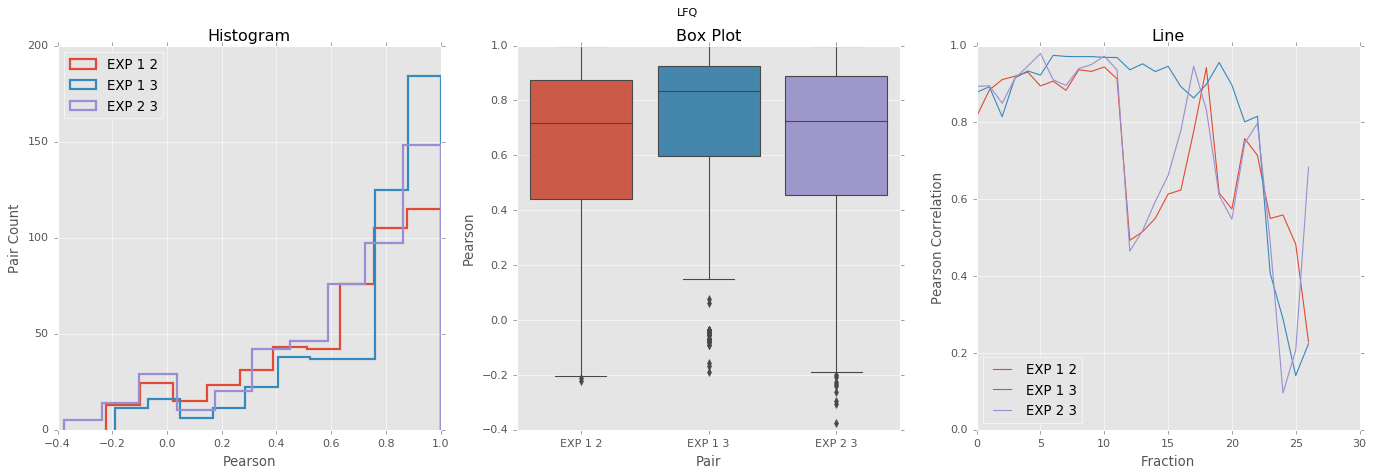

In [765]:
make_corr_plot(res['lfq'][1], res['lfq'][2], suptitle='LFQ')

In [6]:
def plot_line(df, ax, 
              new_ticks={'label':'MW kDa',
                      'values': {
                      6:'2000', 
                      9:'600', 
                      #4:'132', 
                      19:'66', 
                      }},
              legend=False):
    plt.style.use('ggplot')
    #remove all zero entries
    df.fillna(0,inplace=True)
    df = df[(df.T != 0).any()]
    df.T.plot(ax=ax)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(1,4))
    ax.set_xticks( [n for n in range(df.shape[1])])
    ax.set_xticklabels( [n for n in range(df.shape[1])])
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),  
              fancybox=True, framealpha=0.5, fontsize = 'small')
    else:
        ax.legend_.remove()
    ax.set_xlim(-1,df.shape[1]+1)
    ax.set_xlabel(new_ticks['label'], labelpad=1)
    ax.set_ylabel('intensity', rotation=90)
    #ax.set_title(title)
    ticks = [new_ticks['values'][n] if n in new_ticks['values'] else '' for n in range(1, df.shape[1], 1) ]                    
    ax.set_xticklabels(ticks)

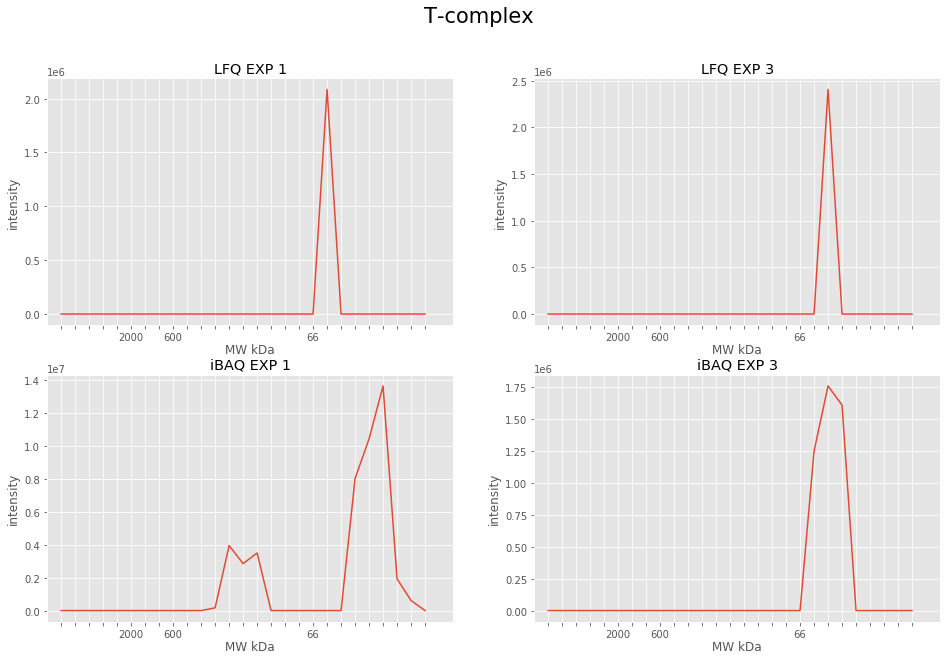

In [17]:
plt.style.use('ggplot')
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,10))

prots = set([
'Tb927.11.16760',
'Tb927.10.8190',
'Tb927.11.14250',
'Tb927.8.3150',
'Tb927.11.3240',
'Tb927.11.1900'
])

prots = set([
'Tb927.3.4000',
'Tb927.10.160',
 'Tb927.11.6210',
'Tb927.10.11750',   
])

prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])

plot_line(res['ibaq'][0][1].loc[prots], axes[1,0])
plot_line(res['ibaq'][0][2].loc[prots], axes[1,1])

axes[0,0].set_title('LFQ EXP 1')
axes[0,1].set_title('LFQ EXP 3')
axes[1,0].set_title('iBAQ EXP 1')
axes[1,1].set_title('iBAQ EXP 3')
#axes[1,0].set_title('EXP 2')
#axes[1,1].set_title('EXP 2 corrected')

plt.suptitle('T-complex',fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


KeyError: 'lfq2'

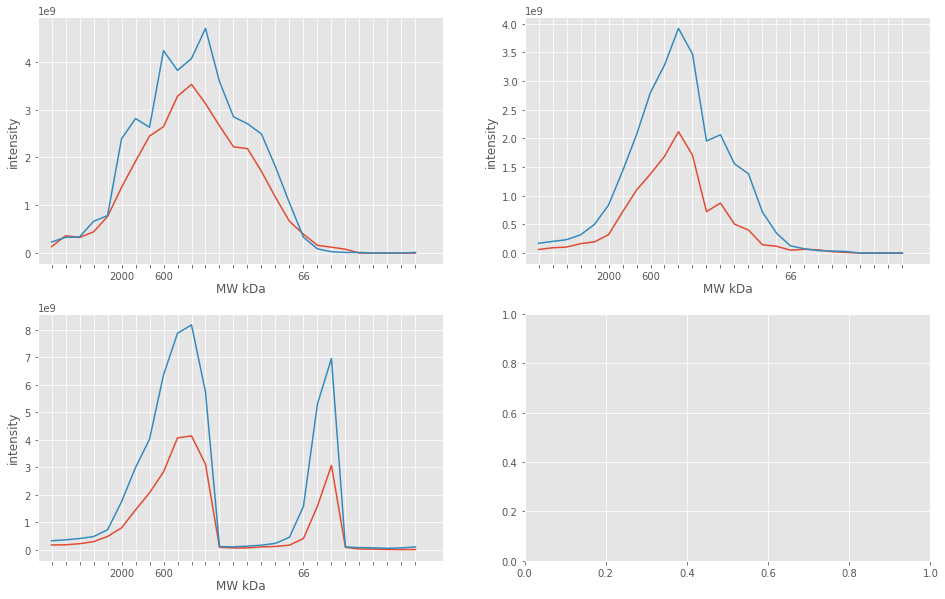

In [8]:
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,10))

prots = set([
'Tb927.11.9980',
'Tb927.11.1450'
])

prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][1].loc[prots], axes[1,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])
plot_line(res['lfq2'][0][1].loc[prots], axes[1,1])

axes[0,0].set_title('EXP 1')
axes[0,1].set_title('EXP 3')
axes[1,0].set_title('EXP 2')
axes[1,1].set_title('EXP 2 corrected')

plt.suptitle('oxoglutarate',fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


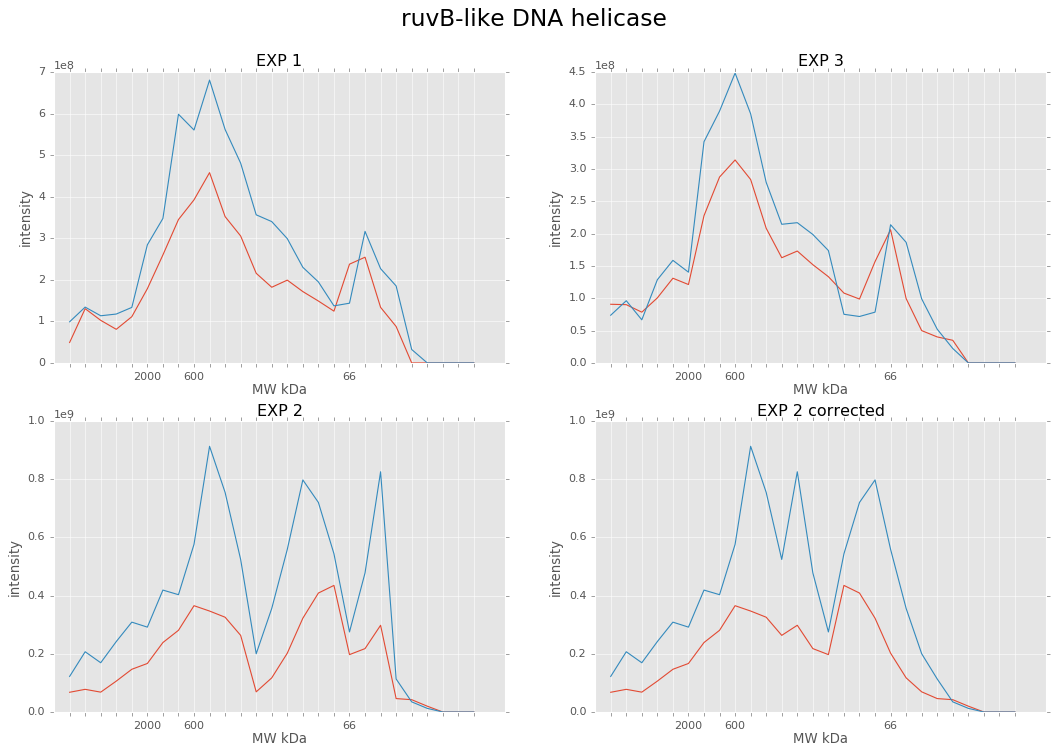

In [26]:
prots = set([
'Tb927.4.1270',
'Tb927.4.2000'
])
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,10))
prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][1].loc[prots], axes[1,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])
plot_line(res['lfq2'][0][1].loc[prots], axes[1,1])

axes[0,0].set_title('EXP 1')
axes[0,1].set_title('EXP 3')
axes[1,0].set_title('EXP 2')
axes[1,1].set_title('EXP 2 corrected')

plt.suptitle('ruvB-like DNA helicase',fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


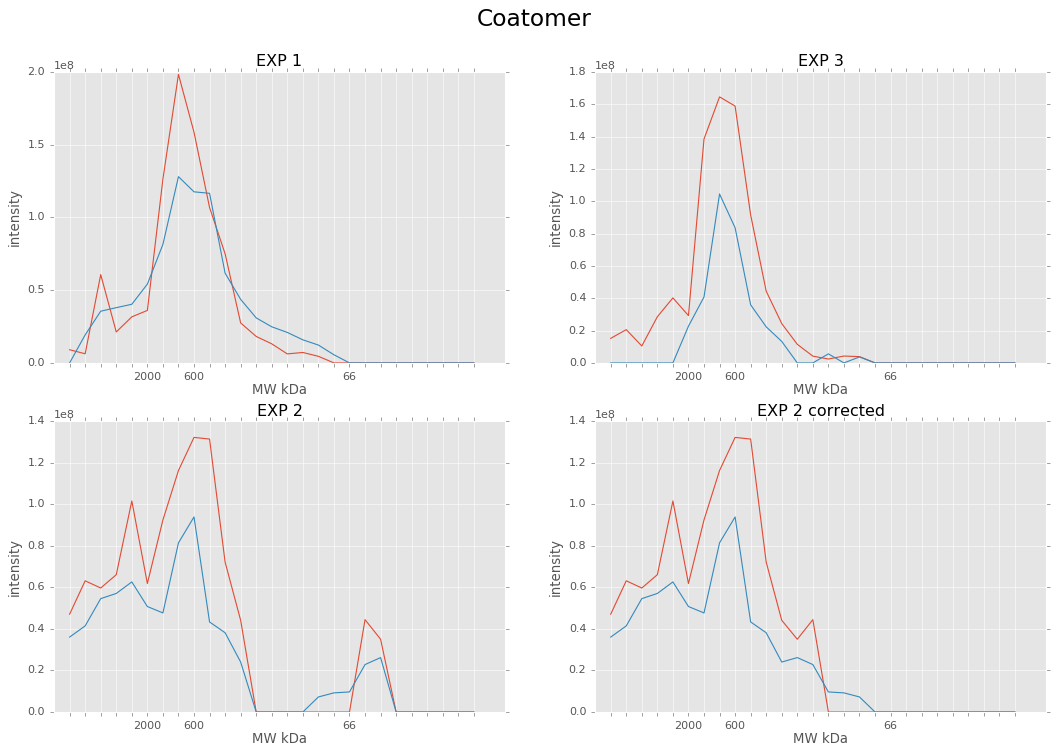

In [27]:
prots = set([
'Tb927.1.2570', 
    'Tb927.11.11900'
])
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,10))
prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][1].loc[prots], axes[1,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])
plot_line(res['lfq2'][0][1].loc[prots], axes[1,1])

axes[0,0].set_title('EXP 1')
axes[0,1].set_title('EXP 3')
axes[1,0].set_title('EXP 2')
axes[1,1].set_title('EXP 2 corrected')

plt.suptitle('Coatomer',fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


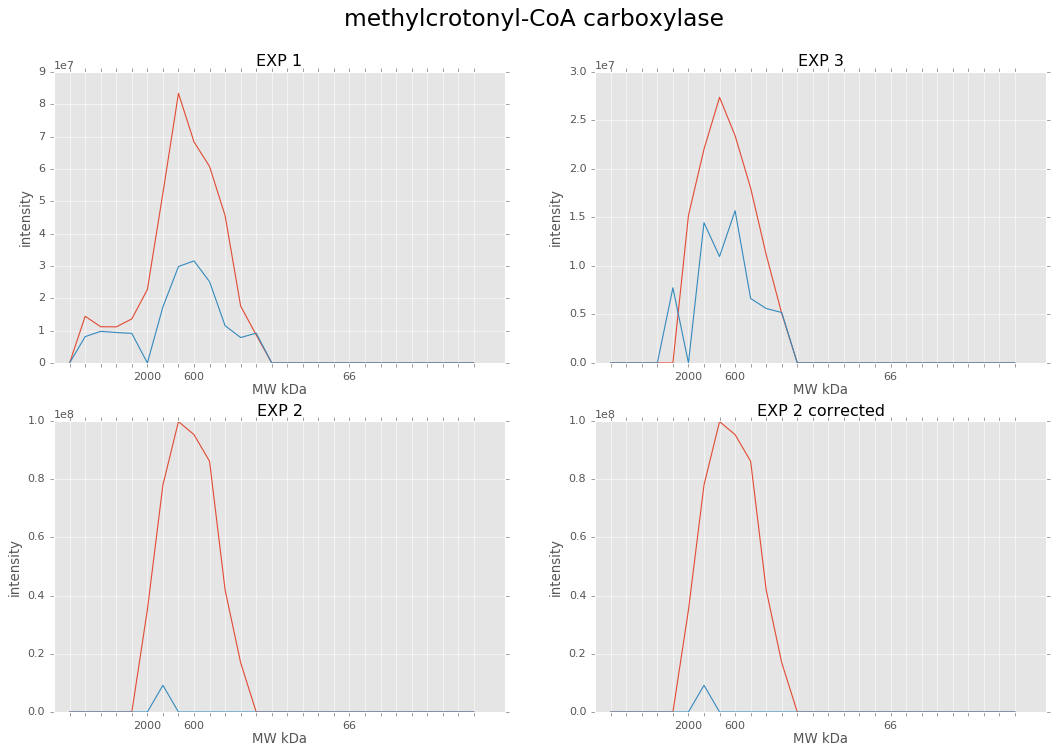

In [28]:
prots = set([
'Tb927.11.6630',
    'Tb927.8.6970'
])
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,10))
prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][1].loc[prots], axes[1,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])
plot_line(res['lfq2'][0][1].loc[prots], axes[1,1])

axes[0,0].set_title('EXP 1')
axes[0,1].set_title('EXP 3')
axes[1,0].set_title('EXP 2')
axes[1,1].set_title('EXP 2 corrected')

plt.suptitle('methylcrotonyl-CoA carboxylase',fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


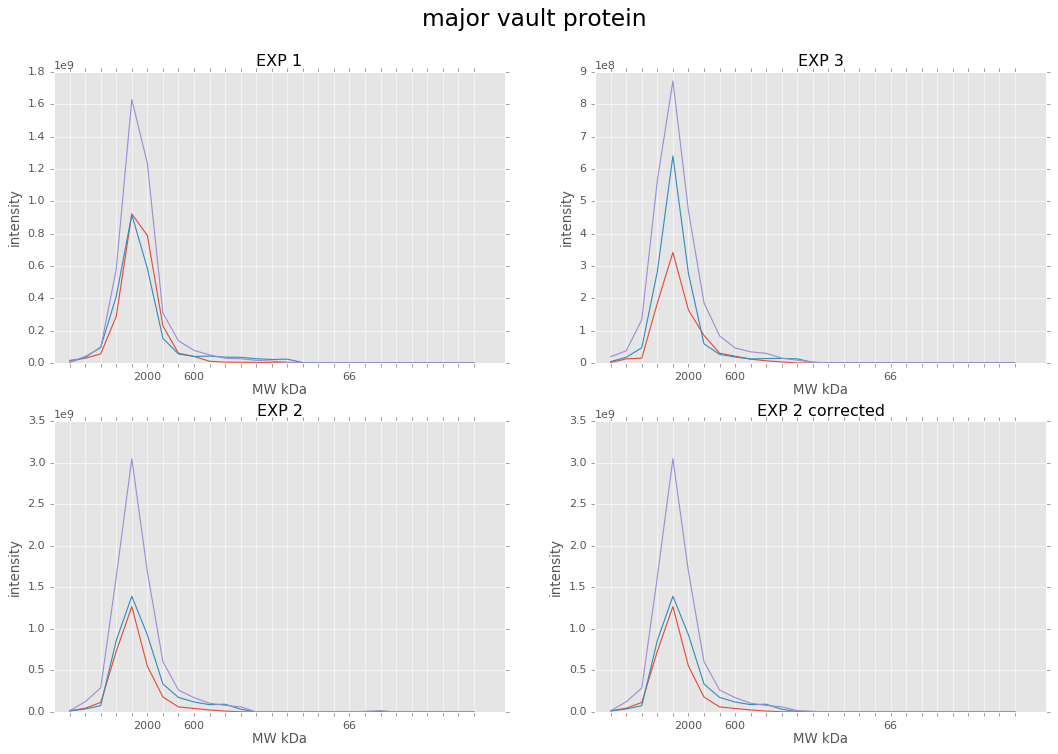

In [29]:
prots = set([
'Tb927.10.1990', 
    'Tb927.10.6310', 
    'Tb927.5.4460'
])
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,10))
prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][1].loc[prots], axes[1,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])
plot_line(res['lfq2'][0][1].loc[prots], axes[1,1])

axes[0,0].set_title('EXP 1')
axes[0,1].set_title('EXP 3')
axes[1,0].set_title('EXP 2')
axes[1,1].set_title('EXP 2 corrected')

plt.suptitle('major vault protein',fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#compare_plots(prots, smoothing=3)

In [30]:
def make_plot(df=pd.DataFrame(), 
              x='', y='', hue='', ax='', 
              legend=False, title =False):
    import seaborn as sns
    #fig, ax = plt.subplots()
    sns.boxplot(x=x, y=y, hue=hue, data=df, palette="PRGn", ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if title:
        ax.set_title(title)
    else:
        ax.set_title(hue)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set_visible(legend)
    #ax.legend.visible=False
 

In [ ]:
evidence_list = []
for exp in ['exp1','exp2','exp3']:
    fpath = os.path.join('in_data', exp, 'evidence.txt')
    evidence = pd.read_csv(fpath, sep='\t')
    evidence['prot_id']=[utilities.clean_id(n) for n in evidence['Leading Razor Protein']]
    evidence = evidence[evidence.prot_id.isin(res['lfq'][0][0].index)]
    evidence['exp']=exp
    evidence_list.append(evidence)

In [ ]:
evidence = pd.concat(evidence_list)

In [ ]:
evidence.head()
evidence['count_pep']=1

In [ ]:
temp = evidence[['DSSTP_K','DSSTP_n_term','count_pep', 'Missed cleavages', 'Fraction','exp']].groupby(["Fraction",'exp']).sum()
temp['fc_DSSTP_K']=temp['DSSTP_K']/temp['count_pep']
temp['fc_DSSTP_n_term']=temp['DSSTP_n_term']/temp['count_pep']
temp.head()
temp['Fraction']=[n[0] for n in temp.index.values]
temp['Experiment']=[n[1] for n in temp.index.values]

In [ ]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(ax=ax, x='Fraction', y='fc_DSSTP_K', hue='Experiment',data=temp)
ax.set_ylabel('Fraction of Modified Peptides')
plt.title('DSSTP on K')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(ax=ax, x='Fraction', y='Missed cleavages', hue='Experiment', data=temp)
ax.set_ylabel('Absolute Number of Modified Peptides')
plt.title('Missed cleavages')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(ax=ax, x='Fraction', y='DSSTP_K', hue='Experiment', data=temp)
ax.set_ylabel('Absolute Number of Modified Peptides')
plt.title('DSSTP on K')
plt.show()

In [ ]:
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(12,4))   
evidence['Log10_Intensity']=np.log10(evidence['Intensity'])
make_plot(df=evidence, x='exp', y='Log10_Intensity', hue='Charge', ax=axes, legend=True, title='Charge')
plt.show()

In [ ]:
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(24,8))   
evidence['Log10_Intensity']=np.log10(evidence['Intensity'])
make_plot(df=evidence, x='Fraction', y='Log10_Intensity', hue='exp', ax=axes, legend=True, title='Charge')
plt.show()

In [ ]:
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(12,4))   
make_plot(df=evidence, x='exp', y='Score', hue='Type',ax=axes, legend=True, title='Type')
plt.xlabel('Fraction')
plt.show()

In [ ]:
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(12,4))   
make_plot(df=evidence, x='exp', y='Score', hue='Type',ax=axes, legend=True, title='Type')
plt.xlabel('Fraction')
plt.show()
#evidence['Type'].value_counts().plot(kind='bar')

In [ ]:
temp = evidence['Missed cleavages'].value_counts()/evidence['Missed cleavages'].value_counts().loc[0]
temp.sort_index(inplace=True)
temp.plot(kind='bar')

In [ ]:
del evidence['count_pep']
ref_df['class_codes']=ref_df['Group'].cat.codes

In [ ]:
cat = ['Modifications', 'Type', 'Raw file','Reverse','Potential contaminant']
num = []
for col in evidence.columns:
    if evidence[col].dtype == object:
        print(col, 'yes')
    else:
        num.append(col)

In [ ]:
for col in cat:
    evidence[col]=evidence[col].astype('category').cat.codes

In [ ]:
y=evidence['exp'].copy()
y=y.replace('exp3', 'exp1')
y=y.replace('exp1',1)
y=y.replace('exp2',0)
y=y.astype(int)

In [ ]:
y.value_counts()

In [ ]:
train_features = cat+num
train_features = [n for n in train_features if n not in ['exp', 'prot_id', 'Experiment',
                                                         'Sequence', 'Modified sequence',
                                                         'Log10_Intensity','id', 'Raw file','Best MS/MS',
                                                         'Calibrated retention time start',
                                                         'Calibrated retention time finish',
                                                         'MS/MS Scan Number',
                                                         'Calibrated retention time',
                                                         'Retention time calibration',
                                                         'Fraction',
                                                         'Uncalibrated - Calibrated m/z [ppm]',
                                                         'Uncalibrated - Calibrated m/z [Da]',
                                                         'Retention time',
                                                        
                                                        ]]
train_features = [n for n in train_features if 'IDs' not in n]
train_features = [n for n in train_features if ' ID' not in n]
train = evidence[train_features]
train['y']=y.values
#train = train[train['Fraction']<12]
train_set = lgb.Dataset(train[train_features], train['y'])
for f  in train_features:
    print (f)

In [ ]:
#machine learning
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb
import shap

In [ ]:
N_FOLDS = 5

params = params = {
        'is_unbalance':True,
        }
cv_results = lgb.cv(params, 
                    train_set, 
                    nfold = N_FOLDS, 
                    num_boost_round = 10000, 
                    early_stopping_rounds = 5, 
                    metrics = 'auc', seed = 50,
                    verbose_eval=100)
    
best_score = max(cv_results['auc-mean'])
optimal_rounds =len(cv_results['auc-mean']) 

model_1 = lgb.LGBMClassifier(
            n_estimators=optimal_rounds+1,
            is_unbalance=True,
            objective= 'binary',
            )

model_1.fit(train[train_features], train['y'])
print (f'the model score is {best_score:.3f}, after {optimal_rounds} boosting rounds')
starting_score = best_score

In [ ]:
print(best_score)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_1.feature_importances_, train_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_1.feature_importances_, train_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [ ]:
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(24,8))   
make_plot(df=evidence, x='Fraction', y='Retention time calibration', hue='exp', ax=axes, legend=True, title='Retention time calibration')
plt.show()

In [ ]:
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(24,8))   
make_plot(df=evidence[evidence['Fraction']<14], x='Fraction', y='Retention time calibration', hue='exp', ax=axes, legend=True, title='Retention time calibration')
plt.show()

In [ ]:
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(24,8))   
make_plot(df=evidence, x='Fraction', y='Retention time', hue='exp', ax=axes, legend=True, title='Retention time')
plt.show()

In [ ]:
fig,axes = plt.subplots(ncols=1, nrows=1, figsize=(24,8))   
make_plot(df=evidence, x='Fraction', y='Calibrated retention time', hue='exp', ax=axes, legend=True, title='Retention time')
plt.show()

In [ ]:
#Now we use the SHAP scoring system to visualise 
#the most important features for the model
explainer = shap.TreeExplainer(model_1)
shap_values = explainer.shap_values(evidence[train_features])
#shap.summary_plot(shap_values, 
                  #train[train_features],
                  #max_display=100)

In [ ]:
shap.summary_plot(shap_values, 
                  evidence[train_features],
                  max_display=10)

In [ ]:
headers = []
data = []
for label in ['lfq', 'msms', 'ibaq', 'upep']:
    for df_index in [0,2]:
        corr = res[label][0][df_index].T.corr()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
        parz_data = upper.unstack().dropna()
        data.append(parz_data)
        headers.append(label+'_'+str(df_index))

In [ ]:
merge = pd.concat(data,axis=1)
merge.columns = headers
merge['mean']=merge.mean(axis=1)
merge.sort_values('mean',ascending=False,inplace=True)
merge.head()

In [ ]:
merge.shape
merge.to_csv('all.csv')

In [31]:
merge=pd.read_csv('all.csv',index_col=[0,1])
select=merge[merge['mean']>0.95]

In [32]:
desc_dict = {}
from Bio import SeqIO
for record in SeqIO.parse("in_data/TriTrypDB-37_TbruceiTREU927_AnnotatedProteins.fasta", "fasta"):
    
    #print(record.description)
    if '|' in record.description:
        desc = record.description.split(' | ')[4].split('=')[1].strip()
    else:
        desc = record.description
    
    desc_dict[utilities.clean_id(record.id)]=desc

In [33]:
select['prot_1'] = [desc_dict[n[0]] for n in select.index.values]
select['prot_2'] = [desc_dict[n[1]] for n in select.index.values]
select.iloc[20:].head(5)

,,lfq_0,lfq_2,msms_0,msms_2,ibaq_0,ibaq_2,upep_0,upep_2,mean,prot_1,prot_2
prot_id,prot_id.1,,,,,,,,,,,
Tb927.11.2430,Tb927.5.3030,0.983652,0.988643,0.931979,0.987823,0.998011,0.996402,0.958231,0.987525,0.979033,"Cytoplasmic dynein 2 heavy chain (DYNC2H2), pu...",Intraflagellar transport protein 121
Tb927.1.880,Tb927.9.7720,0.974817,0.988387,0.969534,0.968389,0.993398,0.976986,0.987866,0.965555,0.978116,"Midasin, putative",predicted tetratricopeptide repeat protein
Tb927.2.4400,Tb927.5.4040,0.964027,0.945869,0.990074,0.961130,0.992134,0.989314,0.991582,0.985818,0.977494,"SSU ribosomal protein, mitochondrial, putative","Mitochondrial SSU ribosomal protein, putative"
Tb927.6.1830,Tb927.5.3030,0.969571,0.967529,0.973702,0.979848,0.995360,0.974806,0.983148,0.975666,0.977454,"Cleavage stimulation factor subunit 50, putative",Intraflagellar transport protein 121
Tb927.7.6980,Tb927.4.3810,0.979126,0.979449,0.989136,0.961951,0.982113,0.986355,0.987562,0.948270,0.976745,Mono-functional DNA-alkylating methyl methanes...,"DNA-directed RNA polymerase II subunit 2, puta..."


In [34]:
select.head()

,,lfq_0,lfq_2,msms_0,msms_2,ibaq_0,ibaq_2,upep_0,upep_2,mean,prot_1,prot_2
prot_id,prot_id.1,,,,,,,,,,,
Tb927.11.2430,Tb927.4.560,0.993733,0.994488,0.981619,0.993747,0.996258,0.995580,0.993180,0.994595,0.992900,"Cytoplasmic dynein 2 heavy chain (DYNC2H2), pu...","Cytoplasmic dynein 2 heavy chain (DYNC2H1), pu..."
Tb927.1.4310,Tb927.4.2080,0.997988,0.943906,0.994782,0.993135,0.997753,0.996969,0.992120,0.992762,0.988677,Flagellum attachment zone protein 2,Coiled-coil and C2 domain-containing protein
Tb927.3.930,Tb927.11.3250,0.992637,0.981083,0.995194,0.960843,0.992317,0.992989,0.983054,0.985043,0.985395,"dynein heavy chain, putative","dynein heavy chain, putative"
Tb927.1.880,Tb927.5.2890,0.977940,0.993752,0.962893,0.986356,0.995900,0.985005,0.987218,0.986994,0.984507,"Midasin, putative",AAA domain (dynein-related subfamily)/von Will...
Tb927.11.2430,Tb927.9.7720,0.984996,0.986003,0.971124,0.980291,0.992218,0.995504,0.982810,0.978963,0.983989,"Cytoplasmic dynein 2 heavy chain (DYNC2H2), pu...",predicted tetratricopeptide repeat protein


In [35]:
def add_max(prot):
    final = []
    for label in ['lfq', 'msms', 'ibaq', 'upep']:
        for df_index in [0,2]:
            temp = np.argmax(res[label][0][df_index].loc[prot])
            temp = int(temp.split(' ')[-1])
            final.append(temp)
    return final
            
add_max('Tb927.4.2080')

[2, 1, 2, 2, 3, 2, 3, 2]

In [ ]:
#import tqdm
#from multiprocessing import Pool
#pool = Pool(processes=10, maxtasksperchild=1)

In [ ]:
#results=[]
#for n in tqdm.tqdm(select.index.values[0:10]):
#    results.append(pool.apply_async(add_max, args=(n[0],)))
#pool.close()
#pool.join()
#results = [r.get() for r in results]
#results[0]

In [ ]:
#results[0]

In [ ]:
#results2=[]
#for n in tqdm.tqdm(select.index.values):
#    results2.append(pool.apply_async(add_max, args=(n[0],)))
#pool.close()
#pool.join()
#results2 = [r.get() for r in results2]
#results2[0]

In [36]:
select['argmax_1'] = [add_max(n[0]) for n in select.index.values]
select['argmax_2'] = [add_max(n[1]) for n in select.index.values]
select.head()

,,lfq_0,lfq_2,msms_0,msms_2,ibaq_0,ibaq_2,upep_0,upep_2,mean,prot_1,prot_2,argmax_1,argmax_2
prot_id,prot_id.1,,,,,,,,,,,,,
Tb927.11.2430,Tb927.4.560,0.993733,0.994488,0.981619,0.993747,0.996258,0.995580,0.993180,0.994595,0.992900,"Cytoplasmic dynein 2 heavy chain (DYNC2H2), pu...","Cytoplasmic dynein 2 heavy chain (DYNC2H1), pu...","[7, 7, 7, 7, 8, 7, 7, 7]","[7, 7, 7, 7, 8, 7, 7, 7]"
Tb927.1.4310,Tb927.4.2080,0.997988,0.943906,0.994782,0.993135,0.997753,0.996969,0.992120,0.992762,0.988677,Flagellum attachment zone protein 2,Coiled-coil and C2 domain-containing protein,"[2, 1, 2, 2, 3, 2, 2, 2]","[2, 1, 2, 2, 3, 2, 3, 2]"
Tb927.3.930,Tb927.11.3250,0.992637,0.981083,0.995194,0.960843,0.992317,0.992989,0.983054,0.985043,0.985395,"dynein heavy chain, putative","dynein heavy chain, putative","[7, 1, 6, 7, 7, 7, 6, 7]","[7, 1, 7, 7, 7, 7, 7, 7]"
Tb927.1.880,Tb927.5.2890,0.977940,0.993752,0.962893,0.986356,0.995900,0.985005,0.987218,0.986994,0.984507,"Midasin, putative",AAA domain (dynein-related subfamily)/von Will...,"[7, 7, 7, 8, 8, 7, 8, 8]","[7, 7, 8, 7, 8, 7, 8, 8]"
Tb927.11.2430,Tb927.9.7720,0.984996,0.986003,0.971124,0.980291,0.992218,0.995504,0.982810,0.978963,0.983989,"Cytoplasmic dynein 2 heavy chain (DYNC2H2), pu...",predicted tetratricopeptide repeat protein,"[7, 7, 7, 7, 8, 7, 7, 7]","[7, 7, 7, 7, 8, 7, 7, 7]"


In [37]:
select['argmax_1'] = [np.mean(n) for n in select['argmax_1']]
select['argmax_2'] = [np.mean(n) for n in select['argmax_2']]
select['diff']=abs(select['argmax_1']-select['argmax_2'])
select.head()

,,lfq_0,lfq_2,msms_0,msms_2,ibaq_0,ibaq_2,upep_0,upep_2,mean,prot_1,prot_2,argmax_1,argmax_2,diff
prot_id,prot_id.1,,,,,,,,,,,,,,
Tb927.11.2430,Tb927.4.560,0.993733,0.994488,0.981619,0.993747,0.996258,0.995580,0.993180,0.994595,0.992900,"Cytoplasmic dynein 2 heavy chain (DYNC2H2), pu...","Cytoplasmic dynein 2 heavy chain (DYNC2H1), pu...",7.125,7.125,0.000
Tb927.1.4310,Tb927.4.2080,0.997988,0.943906,0.994782,0.993135,0.997753,0.996969,0.992120,0.992762,0.988677,Flagellum attachment zone protein 2,Coiled-coil and C2 domain-containing protein,2.000,2.125,0.125
Tb927.3.930,Tb927.11.3250,0.992637,0.981083,0.995194,0.960843,0.992317,0.992989,0.983054,0.985043,0.985395,"dynein heavy chain, putative","dynein heavy chain, putative",6.000,6.250,0.250
Tb927.1.880,Tb927.5.2890,0.977940,0.993752,0.962893,0.986356,0.995900,0.985005,0.987218,0.986994,0.984507,"Midasin, putative",AAA domain (dynein-related subfamily)/von Will...,7.500,7.500,0.000
Tb927.11.2430,Tb927.9.7720,0.984996,0.986003,0.971124,0.980291,0.992218,0.995504,0.982810,0.978963,0.983989,"Cytoplasmic dynein 2 heavy chain (DYNC2H2), pu...",predicted tetratricopeptide repeat protein,7.125,7.125,0.000


In [39]:
select = select[(select['argmax_1']<16)&(select['argmax_1']>4)]
select = select[(select['argmax_2']<16)&(select['argmax_2']>4)]
select.sort_values('mean',inplace=True)
select.head()

,,lfq_0,lfq_2,msms_0,msms_2,ibaq_0,ibaq_2,upep_0,upep_2,mean,prot_1,prot_2,argmax_1,argmax_2,diff
prot_id,prot_id.1,,,,,,,,,,,,,,
Tb927.8.1840,Tb927.10.3520,0.941351,0.899022,0.930732,0.968283,0.965204,0.993981,0.945716,0.955957,0.950031,"Sec7 domain containing protein, putative",protease regulatory ATPase subunit 4,8.000,7.875,0.125
Tb927.11.3570,Tb927.9.13520,0.974644,0.947665,0.970801,0.891622,0.978722,0.964109,0.967751,0.905805,0.950140,"metallo-peptidase, Clan MA(E) Family M1",Importin 1,15.750,15.375,0.375
Tb927.11.10150,Tb927.5.1510,0.985478,0.964035,0.929280,0.918498,0.963928,0.969721,0.920913,0.949356,0.950151,"Enoyl-CoA hydratase/isomerase family, putative","Mitochondrial SSU ribosomal protein, putative",5.250,4.875,0.375
Tb927.6.1830,Tb927.10.14990,0.964532,0.961195,0.941554,0.919064,0.976679,0.983290,0.892756,0.962475,0.950193,"Cleavage stimulation factor subunit 50, putative",intraflagellar transport protein 80,7.375,7.125,0.250
Tb927.5.3240,Tb927.10.5450,0.945741,0.862771,0.935369,0.946151,0.984766,0.984024,0.966341,0.976455,0.950202,"hypothetical protein, conserved",ISWI complex protein,9.375,9.500,0.125


In [54]:
select.to_csv('select.csv')

In [64]:
select = select.reset_index()
temp = select[select['prot_id'].isin(['Tb927.7.1060'])|select['prot_id.1'].isin(['Tb927.7.1060'])]
temp

,index,prot_id,prot_id.1,lfq_0,lfq_2,msms_0,msms_2,ibaq_0,ibaq_2,upep_0,upep_2,mean,prot_1,prot_2,argmax_1,argmax_2,diff
90,90,Tb927.7.1060,Tb927.11.7210,0.945719,0.980403,0.899161,0.951943,0.956446,0.967190,0.964655,0.950862,0.952047,ISWI complex protein,eukaryotic translation initiation factor 2-alp...,9.500,9.625,0.125
180,180,Tb927.7.1060,Tb927.11.11550,0.973957,0.931600,0.940677,0.941444,0.981580,0.972545,0.949760,0.945023,0.954573,ISWI complex protein,"DNA topoisomerase II alpha, putative",9.500,9.500,0.000
188,188,Tb927.7.1060,Tb927.9.2590,0.935830,0.950525,0.964242,0.937191,0.971347,0.966604,0.948079,0.963618,0.954679,ISWI complex protein,"hypothetical protein, conserved",9.500,9.500,0.000
363,363,Tb927.3.4030,Tb927.7.1060,0.923610,0.951282,0.948333,0.966866,0.974318,0.994745,0.971540,0.961735,0.961554,"hypothetical protein, conserved",ISWI complex protein,9.875,9.500,0.375
441,441,Tb927.2.1810,Tb927.7.1060,0.978705,0.979259,0.955452,0.904434,0.985209,0.979929,0.981941,0.964356,0.966161,chromatin-remodeling complex atpase chain iswi,ISWI complex protein,9.375,9.500,0.125
442,442,Tb927.7.1060,Tb927.10.5450,0.980991,0.980951,0.963045,0.915284,0.984850,0.978980,0.973866,0.951556,0.966190,ISWI complex protein,ISWI complex protein,9.500,9.500,0.000


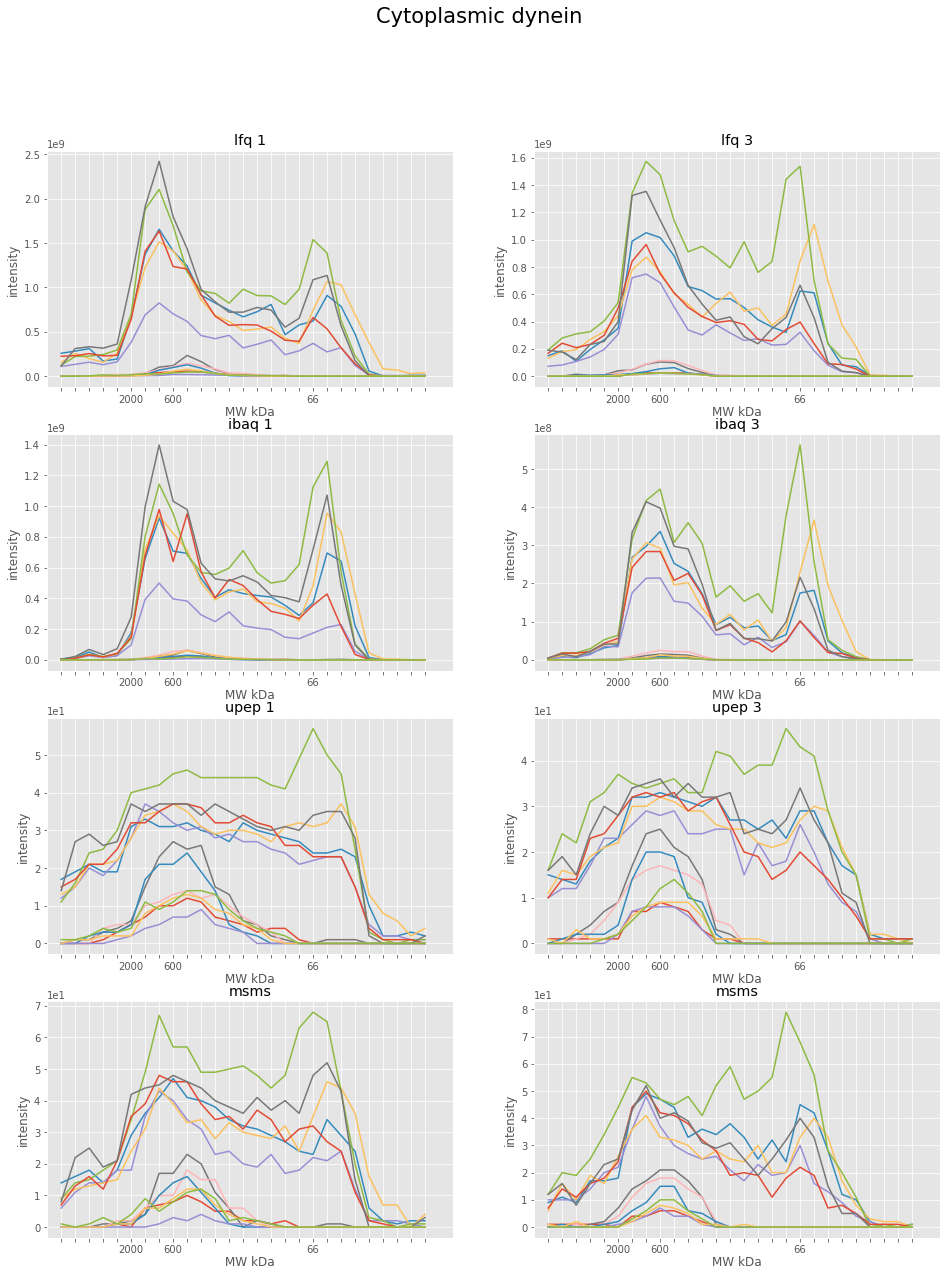

In [200]:
prots = set([
    'Tb927.7.1060', 
    'Tb927.11.7210',
    'Tb927.11.11550', 
    'Tb927.9.2590',  
    'Tb927.3.4030', 
    'Tb927.2.1810',
    'Tb927.10.5450',
    'Tb927.11.16760',
'Tb927.10.8190',
'Tb927.11.14250',
'Tb927.8.3150',
'Tb927.11.3240',
'Tb927.11.1900'

])
fig,axes = plt.subplots(ncols=2,nrows=4,figsize=(16,20))
prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])
plot_line(res['ibaq'][0][0].loc[prots], axes[1,0])
plot_line(res['ibaq'][0][2].loc[prots], axes[1,1])
plot_line(res['upep'][0][0].loc[prots], axes[2,0])
plot_line(res['upep'][0][2].loc[prots], axes[2,1])
plot_line(res['msms'][0][0].loc[prots], axes[3,0])
plot_line(res['msms'][0][2].loc[prots], axes[3,1])


axes[0,0].set_title('lfq 1')
axes[0,1].set_title('lfq 3')
axes[1,0].set_title('ibaq 1')
axes[1,1].set_title('ibaq 3')
axes[2,0].set_title('upep 1')
axes[2,1].set_title('upep 3')
axes[3,0].set_title('msms')
axes[3,1].set_title('msms')
plt.suptitle('Cytoplasmic dynein', fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#compare_plots(prots, smoothing=3)

['Tb927.10.2900', 'Tb927.3.4500', 'Tb927.8.1860', 'Tb927.9.12650']


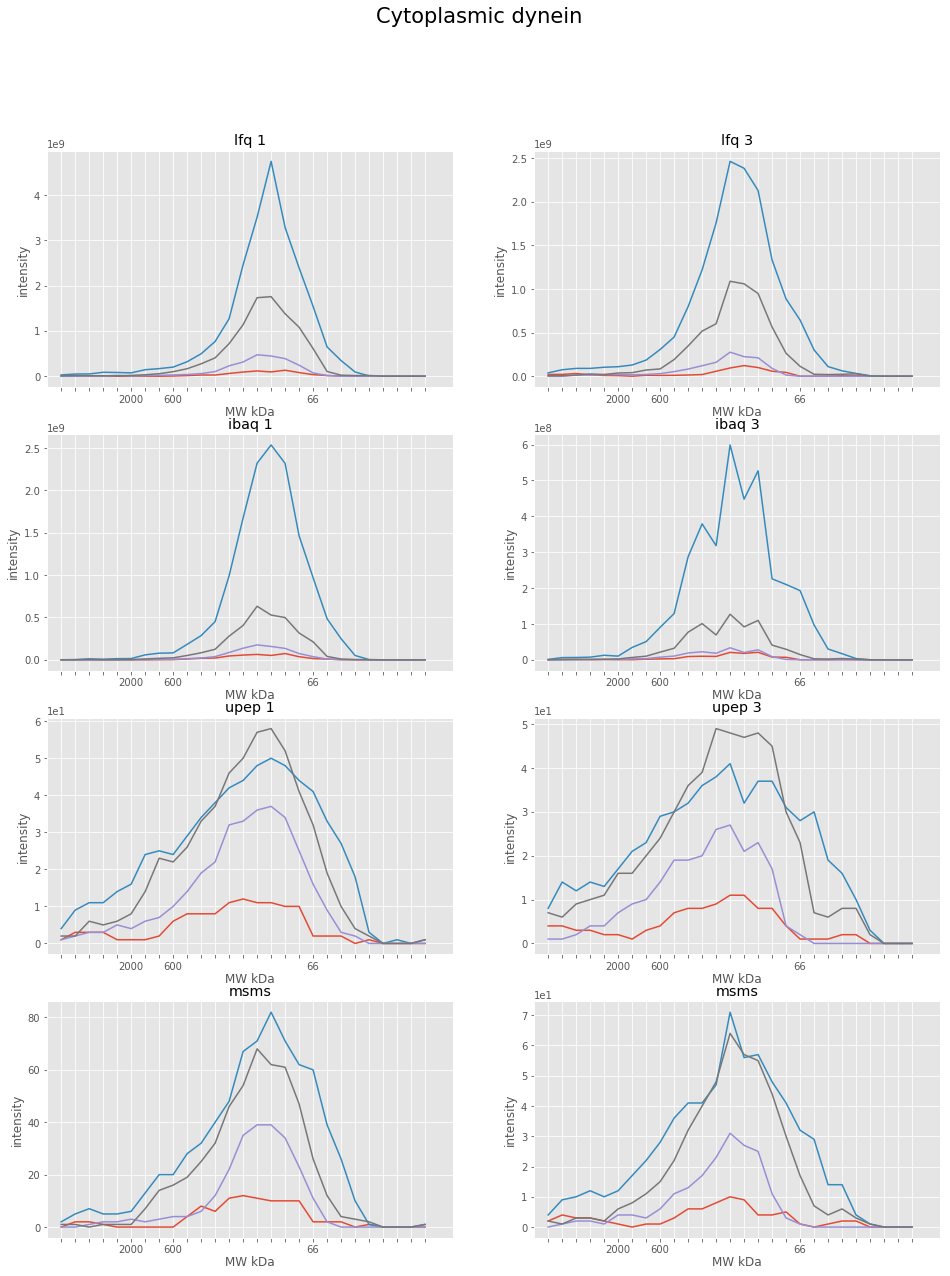

In [450]:
'''
prots = set([
'Tb927.5.2090',
'Tb927.3.2490',
'Tb927.9.9730',
'Tb927.11.14330',        
])
'''
prots = set([
'Tb927.9.12650',
'Tb927.3.4500',
'Tb927.10.2900',
'Tb927.11.12710',   
'Tb927.8.1860',     
])
fig,axes = plt.subplots(ncols=2,nrows=4,figsize=(16,20))
prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
print(prots)
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])
plot_line(res['ibaq'][0][0].loc[prots], axes[1,0])
plot_line(res['ibaq'][0][2].loc[prots], axes[1,1])
plot_line(res['upep'][0][0].loc[prots], axes[2,0])
plot_line(res['upep'][0][2].loc[prots], axes[2,1])
plot_line(res['msms'][0][0].loc[prots], axes[3,0])
plot_line(res['msms'][0][2].loc[prots], axes[3,1])


axes[0,0].set_title('lfq 1')
axes[0,1].set_title('lfq 3')
axes[1,0].set_title('ibaq 1')
axes[1,1].set_title('ibaq 3')
axes[2,0].set_title('upep 1')
axes[2,1].set_title('upep 3')
axes[3,0].set_title('msms')
axes[3,1].set_title('msms')
plt.suptitle('Cytoplasmic dynein', fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#compare_plots(prots, smoothing=3)

In [8]:
plt.style.use('ggplot')
import tqdm
#clusters dataframe with different distances
#compute dendogram and than cutting it at different distances
def make_clustering_df(in_df = pd.DataFrame(), 
                       min_number_of_clusters=4,
                       res_df_name = '',
                       method='', metric=''):
    
    link = sch.linkage(in_df, method, metric)
    
    den = sch.dendrogram(link, 
                         color_threshold=20, 
                         orientation='left')
    #plt.show()
    #print ('done den')
    cut_distances = np.arange(0,5,0.01)
    done = set()
    
    for cut_distance in tqdm.tqdm(cut_distances):
        clusters = sch.fcluster(link, cut_distance, criterion='distance')
        in_df['clusters_'+str(cut_distance)]=clusters
        n_of_clusters =  in_df['clusters_'+str(cut_distance)].value_counts().shape[0]
        
        if n_of_clusters not in done:
            done.add(n_of_clusters)
            #print (cut_distance, n_of_clusters)
        else:
            del in_df['clusters_'+str(cut_distance)]
        if n_of_clusters <=min_number_of_clusters:
            break
        
    res_df = in_df[[n for n in in_df.columns if 'clusters_' in n]]
    res_df.to_csv(res_df_name)
    print ('done')
    print (res_df.shape) 

100%|██████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 47.87it/s]


done
(3532, 335)


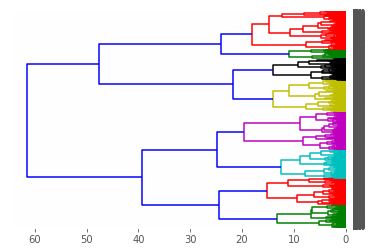

In [9]:
plt.style.use('ggplot')
make_clustering_df(in_df = res['upep'][0][0].apply(utilities.norm_max,1), 
                    min_number_of_clusters=4,
                    res_df_name = os.path.join( 'clusters', 'upep_1.csv'),
                    method='ward' ,
                    metric='euclidean'
                       )


100%|██████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.07it/s]


done
(3532, 340)


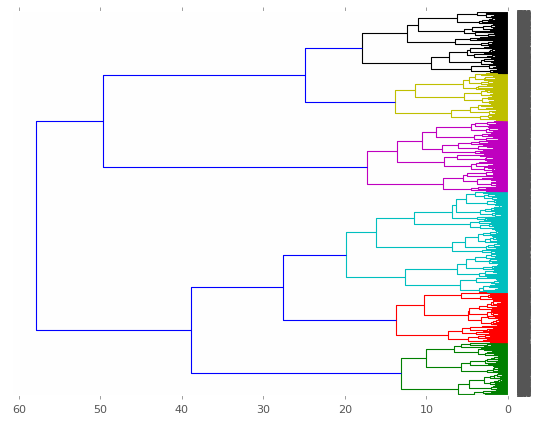

In [76]:
plt.style.use('ggplot')
make_clustering_df(in_df = res['upep'][0][2].apply(utilities.norm_max,1), 
                    min_number_of_clusters=4,
                    res_df_name = os.path.join( 'clusters', 'upep_3.csv'),
                    method='ward' ,
                    metric='euclidean'
                       )


In [84]:
from IPython.display import Image
from IPython.core.display import HTML
import scipy.cluster.hierarchy as sch
import gc
from ipyparallel import Client
import os
import pprint

import pprint
pp = pprint.PrettyPrinter(indent=4)

#create some paths to push to the cluster engines
data_path = 'd:/git/fernando/final_run/'
res_go_path = 'd:/git/fernando/final_run/go_results/'
res_random_go_path = 'd:/git/fernando/final_run/go_results_random/'
in_go='d:/git/fernando/Fernando8mM60/indata/go/go-basic_2.obo'
in_assoc='d:/git/fernando/Fernando8mM60/indata/go/associations_2.txt'

rc = Client()
rc[:].push(dict(
    data_path=data_path,
    res_go_path=res_go_path,
    res_random_go_path=res_random_go_path,
    in_go=in_go,
    in_assoc=in_assoc,
    res = res
))

dview = rc.load_balanced_view()
print ('n of workers:', len(dview))
print (len(rc))
print (res_random_go_path)
print (res_go_path)
print (data_path)

n of workers: 10
10
d:/git/fernando/final_run/go_results_random/
d:/git/fernando/final_run/go_results/
d:/git/fernando/final_run/


In [85]:
%%px --local
#add the go term function to the cluster engines
import os
import pandas as pd
from goatools.base import download_go_basic_obo
from goatools.associations import read_associations
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag
import scipy.cluster.hierarchy as sch
import numpy as np
from itertools import combinations
from scipy import stats
from itertools import combinations

print (in_go)
print (in_assoc)
gene_found = list(res['upep'][0][2].index.values)
obodag = GODag(in_go)
geneid2gos = read_associations(in_assoc)
goeaobj = GOEnrichmentStudy(
            gene_found, # List of mouse protein-coding genes
            geneid2gos, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh'])

d:/git/fernando/Fernando8mM60/indata/go/go-basic_2.obo
d:/git/fernando/Fernando8mM60/indata/go/associations_2.txt
load obo file d:/git/fernando/Fernando8mM60/indata/go/go-basic_2.obo
d:/git/fernando/Fernando8mM60/indata/go/go-basic_2.obo: fmt(1.2) rel(2018-09-29) 48,068 GO Terms
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 3,227 out of  3,532 population items found in association
[stdout:0] 
d:/git/fernando/Fernando8mM60/indata/go/go-basic_2.obo
d:/git/fernando/Fernando8mM60/indata/go/associations_2.txt
load obo file d:/git/fernando/Fernando8mM60/indata/go/go-basic_2.obo
d:/git/fernando/Fernando8mM60/indata/go/go-basic_2.obo: fmt(1.2) rel(2018-09-29) 48,068 GO Terms
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 3,227 out of  3,532 population items found in association
[stdout:1] 
d:/git/fernando/Fernando8mM60/indata/go/go-basic_2.obo
d:/git/fernando/Fernando8mM60/indata/go/associations_2.txt
load obo file d:/git/fernando/Fernando8mM6

In [86]:
%%px --local
#function to count the enriched go terms
def score(in_genes, index_res, cut_distance, cluster_id, out_folder):
    print (out_folder)
    def count(goea_results_sig):
            res = {'BP' : 0,
                   'CC' : 0,
                   'MF' : 0,
                   'complex':0}
            for item in goea_results_sig:
                item_list = str(item).split()            
                go_type = item_list[1] 
                res[go_type]+=1
                if 'complex_' in str(item):
                    res['complex']+=1
            return res   
    goea_results_all = goeaobj.run_study(in_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    res = count(goea_results_sig)
    if sum(res.values())>0:
        file_name = 'res_'+str(cut_distance)+'_'+str(cluster_id)+'.txt'
        res_file = open(os.path.join(out_folder, file_name),'w')
        print(res_file)
        res_file.write('\t'.join(['cut_distance','cluster_id','CC','MF','BP','complexes'])+'\n')
        res_file.write('\t'.join( [str(n) for n in [cut_distance,cluster_id,res['CC'],res['MF'],res['BP'],res['complex']]] ))
        res_file.close()
    #return count(goea_results_sig)

In [87]:
def test():
    in_file = 'D:/git/fernando/Fernando8mM60/test/t-complex.txt'
    geneids_study = [n.strip() for n in open(in_file).read().split('\n')]
    #score(geneids_study, 'test_local', 0.04, 2, random_path)
    rc[0].apply(score, geneids_study, 'test_cluster', 0.05, 3, res_random_go_path)
test()

In [88]:
%%px --local
#create a rndom dataset
import random
clustering_df = pd.read_csv('D:/git/fernando/final_run/clusters/upep_1.csv')
clustering_df.set_index('prot_id',inplace=True)


In [89]:
import time
import sys
start_time = time.time()
#res = []

def process_df(clustering_df=pd.DataFrame(), res_path=''):
    for index, col in tqdm.tqdm(enumerate(clustering_df.columns)):
        in_data = clustering_df[col].value_counts()
        in_data = in_data[in_data>=2]
        cut_distance = col.split('_')[-1]
        #print (index, col, cut_distance)
        for cluster in in_data.index.values:
            genes = clustering_df[col][clustering_df[col]==cluster]
            genes = genes.index.values
            #if len(genes) >1:
            #print cluster, len(genes)
            #print 'send', index, cut_distance, cluster, 'to controller'
            dview.apply(score, genes, index, cut_distance, cluster, res_path)
            #print(res_path)
            test = 0
            a=0
            while 1:
                #send more job only if the queue is less than 100
                #to do not run out of memory
                if dview.queue_status()['unassigned']<100:            
                    break
                else:
                    a+=1
                    #print a, 'unassigned:', dview.queue_status()['unassigned']
                    #print 'waited for ', a*1, 'sec'
                    sys.stdout.flush()
                    time.sleep(1)            
                    pass        

##uncomment to run a test
#def test():
#    process_df(clustering_df=clustering_df.iloc[:,388:390], res_path=res_path)
#    process_df(clustering_df=random_df.iloc[:,388:390], res_path=random_path)
#test()


process_df(clustering_df=clustering_df, res_path=res_go_path)

341it [6:30:37, 68.73s/it] 


In [766]:
#counting the outputs
def reduce_res(res_path, outname):
    list_df = [pd.read_table(os.path.join(res_path, file_name),
                             sep='\t') for file_name in os.listdir(res_path)]
    list_df = pd.concat(list_df)
    list_df.sort_values(by='cut_distance', ascending=True, inplace=True)
    print (list_df.head())
    combined = list_df.groupby('cut_distance').sum()
    del combined['cluster_id']
    print (combined.head())
    combined.to_csv(outname)

#reduce_res(res_go_path, res_go_path+'reduced_go_terms.csv')


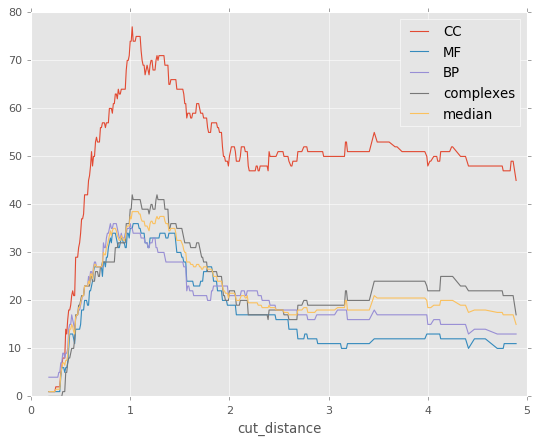

In [91]:
fig,ax = plt.subplots()

combined = pd.read_csv(res_go_path+'reduced_go_terms.csv')
combined.set_index('cut_distance',inplace=True)
combined['median']=combined.median(axis=1)
combined.plot(ax=ax,label='enrichment_go')


In [769]:
def reduce_res(res_path, outname):
    list_df = [pd.read_table(os.path.join(res_path, file_name),
                             sep='\t') for file_name in os.listdir(res_path)]
    list_df = pd.concat(list_df)
    list_df.sort_values(by='cut_distance', ascending=True, inplace=True)
    print (list_df.head())
    combined = list_df.groupby('cut_distance').sum()
    del combined['cluster_id']
    print (combined.head())
    combined.to_csv(outname)
res_go_path='D:/git/fernando/final_run/go_results/ibaq_0/'
reduce_res(res_go_path, res_go_path+'reduced_go_terms.csv')


    BP   CC   MF  cluster_id  complexes  cut_distance  \
0  0.0  4.0  1.0       391.0        0.0          0.12   
0  0.0  0.0  1.0       434.0        0.0          0.12   
0  2.0  7.0  3.0       448.0        4.0          0.12   
0  1.0  8.0  7.0        69.0        5.0          0.12   
0  0.0  6.0  0.0       339.0        2.0          0.13   

  cut_distance,CC,MF,BP,complexes  
0                             NaN  
0                             NaN  
0                             NaN  
0                             NaN  
0                             NaN  
                BP    CC    MF  complexes
cut_distance                             
0.12           3.0  19.0  12.0        9.0
0.13          10.0  35.0  17.0       14.0
0.14          16.0  51.0  26.0       18.0
0.15          25.0  68.0  32.0       22.0
0.16          33.0  90.0  41.0       30.0


In [22]:
res_go_path='D:/git/fernando/final_run/go_results/ibaq_1/'
reduce_res(res_go_path, res_go_path+'reduced_go_terms.csv')

   cut_distance  cluster_id  CC  MF  BP  complexes
0          0.11        2484   1   0   2          0
0          0.12        2469   1   0   2          0
0          0.13        2458   1   0   2          0
0          0.14        2398   2   0   0          1
0          0.14        2443   1   0   3          0
              CC  MF  BP  complexes
cut_distance                       
0.11           1   0   2          0
0.12           1   0   2          0
0.13           1   0   2          0
0.14           3   0   4          1
0.15           5   0   4          3


In [81]:
res_go_path='D:/git/fernando/final_run/go_results/lfq_0/'
reduce_res(res_go_path, res_go_path+'reduced_go_terms.csv')

   cut_distance  cluster_id  CC  MF  BP  complexes
0          0.13         618   1   0   0          1
0          0.14         617   1   0   0          1
0          0.15         614   1   0   0          1
0          0.16         412   2   0   0          2
0          0.16         610   1   0   0          1
              CC  MF  BP  complexes
cut_distance                       
0.13           1   0   0          1
0.14           1   0   0          1
0.15           1   0   0          1
0.16           3   0   0          3
0.17           3   0   0          3


In [137]:
res_go_path='D:/git/fernando/final_run/go_results/lfq_1/'
reduce_res(res_go_path, res_go_path+'reduced_go_terms.csv')

   cut_distance  cluster_id  CC  MF  BP  complexes
0          0.00           1   1   0   0          0
0          0.01           1   1   0   0          0
0          0.02           1   1   0   0          0
0          0.03           1   1   0   0          0
0          0.04           1   1   0   0          0
              CC  MF  BP  complexes
cut_distance                       
0.00           1   0   0          0
0.01           1   0   0          0
0.02           1   0   0          0
0.03           1   0   0          0
0.04           1   0   0          0


In [274]:
res_go_path='D:/git/fernando/final_run/go_results/msms_0/'
reduce_res(res_go_path, res_go_path+'reduced_go_terms.csv')

   cut_distance  cluster_id  CC  MF  BP  complexes
0          0.15         280   2   0   0          1
0          0.16         280   2   0   0          1
0          0.18         279   2   0   0          1
0          0.19         279   2   0   0          1
0          0.20         277   2   0   0          1
              CC  MF  BP  complexes
cut_distance                       
0.15           2   0   0          1
0.16           2   0   0          1
0.18           2   0   0          1
0.19           2   0   0          1
0.20           2   0   0          1


In [275]:
res_go_path='D:/git/fernando/final_run/go_results/msms_1/'
reduce_res(res_go_path, res_go_path+'reduced_go_terms.csv')

   cut_distance  cluster_id  CC  MF  BP  complexes
0          0.00        1695   0   1   0          0
0          0.09        1692   0   1   0          0
0          0.11        1691   0   1   0          0
0          0.13        1690   0   1   0          0
0          0.15        1689   0   1   0          0
              CC  MF  BP  complexes
cut_distance                       
0.00           0   1   0          0
0.09           0   1   0          0
0.11           0   1   0          0
0.13           0   1   0          0
0.15           0   1   0          0


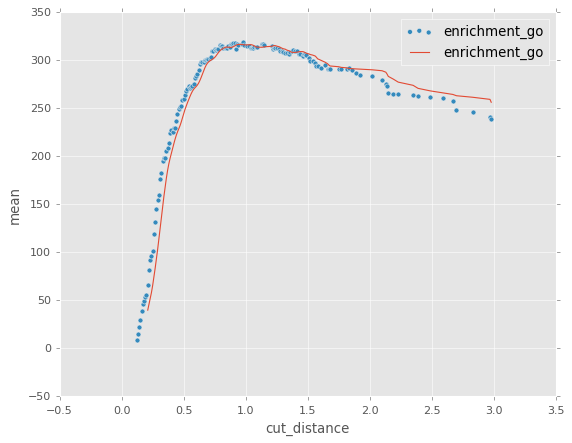

cut_distance     9.300000e-01
BP               2.960000e+02
CC               6.740000e+02
MF               4.060000e+02
complexes        2.070000e+02
mean            3.788015e+137
roll            2.799380e+136
rolls           3.307263e+137
Name: 81, dtype: float64

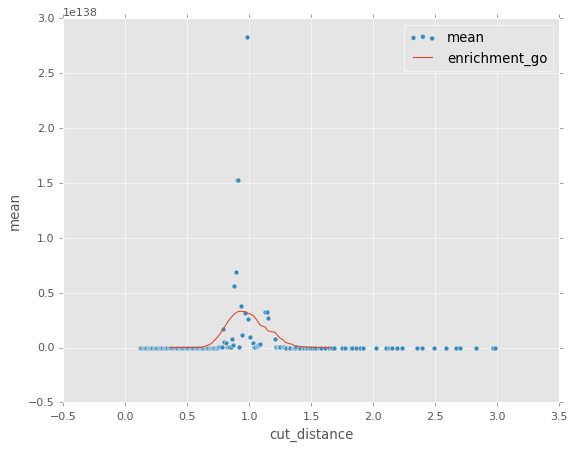

In [770]:
fig,ax = plt.subplots()
res_go_path='D:/git/fernando/final_run/go_results/ibaq_0/'
combined = pd.read_csv(res_go_path+'reduced_go_terms.csv')
#combined.set_index('cut_distance',inplace=True)
combined['mean']=combined.mean(axis=1)
#combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='enrichment_go')
combined['roll']=combined['mean'].rolling(10, win_type='hamming').mean()
combined.plot(kind='line', ax=ax, x='cut_distance', y='roll', label='enrichment_go')
plt.show()
combined.head()
combined.loc[np.argmax(combined['roll'])]
plt.show()
fig,ax=plt.subplots()
combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='mean')
combined['roll']=combined['mean'].rolling(50, win_type='hamming').mean()
combined['rolls']=combined['roll'].shift(-25)
combined.plot(kind='line', ax=ax, x='cut_distance', y='rolls', label='enrichment_go')
combined.loc[np.argmax(combined['rolls'])]

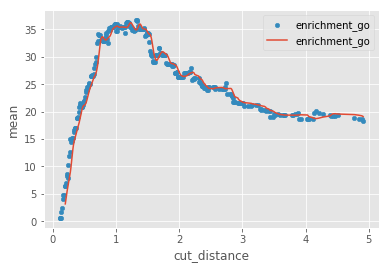

d:\my_env\prediction\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


cut_distance    1.200000e+00
CC              7.700000e+01
MF              2.400000e+01
BP              3.400000e+01
complexes       4.500000e+01
mean            5.480649e+15
roll            2.069689e+15
rolls           3.316783e+15
Name: 109, dtype: float64

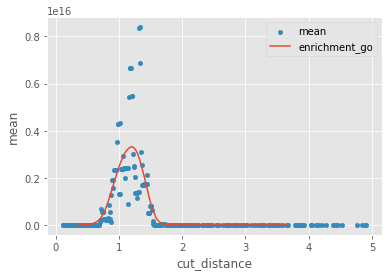

In [235]:
fig,ax = plt.subplots()
res_go_path='D:/git/fernando/final_run/go_results/ibaq_1/'
combined = pd.read_csv(res_go_path+'reduced_go_terms.csv')
#combined.set_index('cut_distance',inplace=True)
combined['mean']=combined.mean(axis=1)
#combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='enrichment_go')
combined['roll']=combined['mean'].rolling(10, win_type='hamming').mean()
combined.plot(kind='line', ax=ax, x='cut_distance', y='roll', label='enrichment_go')
plt.show()
combined.head()
combined.loc[np.argmax(combined['roll'])]

fig,ax=plt.subplots()
combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='mean')
combined['roll']=combined['mean'].rolling(50, win_type='hamming').mean()
combined['rolls']=combined['roll'].shift(-25)
combined.plot(kind='line', ax=ax, x='cut_distance', y='rolls', label='enrichment_go')
combined.loc[np.argmax(combined['rolls'])]

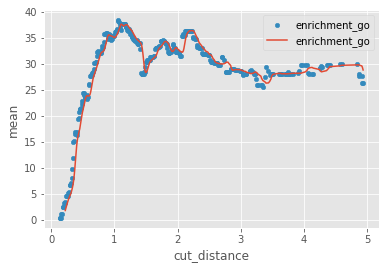

d:\my_env\prediction\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


cut_distance    1.100000e+00
CC              7.700000e+01
MF              3.100000e+01
BP              3.300000e+01
complexes       4.100000e+01
mean            8.014269e+15
roll            2.505803e+15
rolls           1.392296e+16
Name: 97, dtype: float64

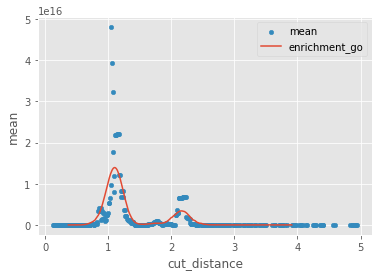

In [236]:
fig,ax = plt.subplots()
res_go_path='D:/git/fernando/final_run/go_results/lfq_0/'
combined = pd.read_csv(res_go_path+'reduced_go_terms.csv')
#combined.set_index('cut_distance',inplace=True)
combined['mean']=combined.mean(axis=1)
#combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='enrichment_go')
combined['roll']=combined['mean'].rolling(10, win_type='hamming').mean()
combined.plot(kind='line', ax=ax, x='cut_distance', y='roll', label='enrichment_go')
plt.show()
combined.head()
combined.loc[np.argmax(combined['roll'])]
combined[combined['cut_distance']<2].sort_values('roll').tail(10)


fig,ax=plt.subplots()
combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='mean')
combined['roll']=combined['mean'].rolling(50, win_type='hamming').mean()
combined['rolls']=combined['roll'].shift(-25)
combined.plot(kind='line', ax=ax, x='cut_distance', y='rolls', label='enrichment_go')
combined.loc[np.argmax(combined['rolls'])]

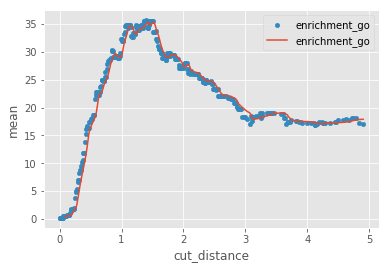

d:\my_env\prediction\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


cut_distance    1.400000e+00
CC              7.700000e+01
MF              3.100000e+01
BP              2.900000e+01
complexes       4.000000e+01
mean            3.130597e+15
roll            7.274220e+14
rolls           1.434204e+15
Name: 140, dtype: float64

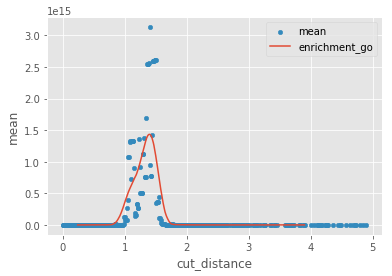

In [237]:
fig,ax = plt.subplots()
res_go_path='D:/git/fernando/final_run/go_results/lfq_1/'
combined = pd.read_csv(res_go_path+'reduced_go_terms.csv')
#combined.set_index('cut_distance',inplace=True)
combined['mean']=combined.mean(axis=1)
#combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='enrichment_go')
combined['roll']=combined['mean'].rolling(10, win_type='hamming').mean()
combined.plot(kind='line', ax=ax, x='cut_distance', y='roll', label='enrichment_go')
plt.show()
combined.head()
combined.loc[np.argmax(combined['roll'])]
combined[combined['cut_distance']<2].sort_values('roll').tail(10)

fig,ax=plt.subplots()
combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='mean')
combined['roll']=combined['mean'].rolling(50, win_type='hamming').mean()
combined['rolls']=combined['roll'].shift(-25)
combined.plot(kind='line', ax=ax, x='cut_distance', y='rolls', label='enrichment_go')
combined.loc[np.argmax(combined['rolls'])]

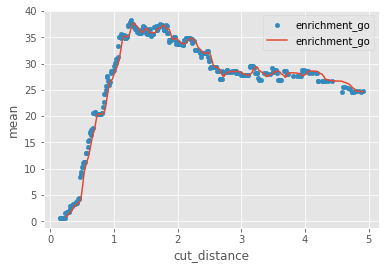

d:\my_env\prediction\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


cut_distance    1.290000e+00
CC              7.700000e+01
MF              2.900000e+01
BP              3.400000e+01
complexes       4.600000e+01
mean            1.852690e+16
roll            1.568258e+15
rolls           1.100593e+16
Name: 113, dtype: float64

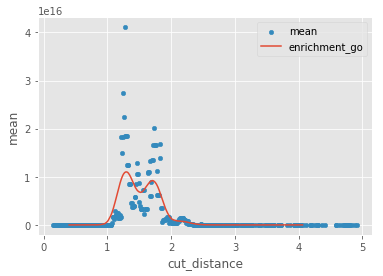

In [276]:
fig,ax = plt.subplots()
res_go_path='D:/git/fernando/final_run/go_results/msms_0/'
combined = pd.read_csv(res_go_path+'reduced_go_terms.csv')
#combined.set_index('cut_distance',inplace=True)
combined['mean']=combined.mean(axis=1)
#combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='enrichment_go')
combined['roll']=combined['mean'].rolling(10, win_type='hamming').mean()
combined.plot(kind='line', ax=ax, x='cut_distance', y='roll', label='enrichment_go')
plt.show()
combined.head()
combined.loc[np.argmax(combined['roll'])]
combined[combined['cut_distance']<2].sort_values('roll').tail(10)

fig,ax=plt.subplots()
combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='mean')
combined['roll']=combined['mean'].rolling(50, win_type='hamming').mean()
combined['rolls']=combined['roll'].shift(-25)
combined.plot(kind='line', ax=ax, x='cut_distance', y='rolls', label='enrichment_go')
combined.loc[np.argmax(combined['rolls'])]

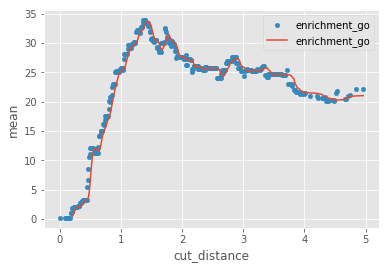

d:\my_env\prediction\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


cut_distance    1.380000e+00
CC              7.400000e+01
MF              2.400000e+01
BP              3.000000e+01
complexes       4.000000e+01
mean            5.154183e+14
roll            2.105320e+13
rolls           1.928459e+14
Name: 126, dtype: float64

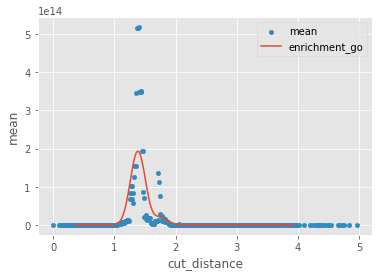

In [277]:
fig,ax = plt.subplots()
res_go_path='D:/git/fernando/final_run/go_results/msms_1/'
combined = pd.read_csv(res_go_path+'reduced_go_terms.csv')
#combined.set_index('cut_distance',inplace=True)
combined['mean']=combined.mean(axis=1)
#combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='enrichment_go')
combined['roll']=combined['mean'].rolling(10, win_type='hamming').mean()
combined.plot(kind='line', ax=ax, x='cut_distance', y='roll', label='enrichment_go')
plt.show()
combined.head()
combined.loc[np.argmax(combined['roll'])]
combined[combined['cut_distance']<2].sort_values('roll').tail(10)

fig,ax=plt.subplots()
combined['mean']=np.exp(combined['mean'])
combined.plot(kind='scatter', ax=ax, x='cut_distance', y='mean', label='mean')
combined['roll']=combined['mean'].rolling(50, win_type='hamming').mean()
combined['rolls']=combined['roll'].shift(-25)
combined.plot(kind='line', ax=ax, x='cut_distance', y='rolls', label='enrichment_go')
combined.loc[np.argmax(combined['rolls'])]

In [458]:
temp = pd.read_csv('clusters/'+'lfq_0.csv',index_col=[0])
selection_a = [n for n in temp.columns.values if (float(n.split('_')[-1])>0.85) and (float(n.split('_')[-1])<3)]# and float(n.split('_')[-1])) < 1.8]
selection_a

['clusters_0.86',
 'clusters_0.87',
 'clusters_0.88',
 'clusters_0.89',
 'clusters_0.9',
 'clusters_0.91',
 'clusters_0.92',
 'clusters_0.93',
 'clusters_0.9400000000000001',
 'clusters_0.9500000000000001',
 'clusters_0.96',
 'clusters_0.97',
 'clusters_0.98',
 'clusters_0.99',
 'clusters_1.0',
 'clusters_1.01',
 'clusters_1.02',
 'clusters_1.03',
 'clusters_1.04',
 'clusters_1.05',
 'clusters_1.06',
 'clusters_1.07',
 'clusters_1.08',
 'clusters_1.09',
 'clusters_1.1',
 'clusters_1.11',
 'clusters_1.12',
 'clusters_1.1300000000000001',
 'clusters_1.1400000000000001',
 'clusters_1.1500000000000001',
 'clusters_1.16',
 'clusters_1.17',
 'clusters_1.18',
 'clusters_1.19',
 'clusters_1.2',
 'clusters_1.21',
 'clusters_1.22',
 'clusters_1.23',
 'clusters_1.24',
 'clusters_1.25',
 'clusters_1.26',
 'clusters_1.27',
 'clusters_1.28',
 'clusters_1.29',
 'clusters_1.3',
 'clusters_1.31',
 'clusters_1.32',
 'clusters_1.33',
 'clusters_1.34',
 'clusters_1.35',
 'clusters_1.36',
 'clusters_1.37',

In [344]:
temp = pd.read_csv('clusters/'+'ibaq_0.csv',index_col=[0])
selection_a = [n for n in temp.columns.values if (float(n.split('_')[-1])>0.85) and (float(n.split('_')[-1])<1.85)]# and float(n.split('_')[-1])) < 1.8]
temp = pd.read_csv('clusters/'+'ibaq_1.csv',index_col=[0])
selection_b = [n for n in temp.columns.values if (float(n.split('_')[-1])>0.85) and (float(n.split('_')[-1])<1.85)]# and float(n.split('_')[-1])) < 1.8]
temp = pd.read_csv('clusters/'+'lfq_0.csv',index_col=[0])
selection_c = [n for n in temp.columns.values if (float(n.split('_')[-1])>0.85) and (float(n.split('_')[-1])<1.85)]# and float(n.split('_')[-1])) < 1.8]
temp = pd.read_csv('clusters/'+'lfq_1.csv',index_col=[0])
selection_d = [n for n in temp.columns.values if (float(n.split('_')[-1])>0.85) and (float(n.split('_')[-1])<1.85)]# and float(n.split('_')[-1])) < 1.8]

cres = open('cres.txt','w')
for a in selection_a:
    for b in selection_b:
        for c in selection_c:
            for d in selection_d:
                all_clusters = []
                temp = pd.read_csv('clusters/'+'ibaq_0.csv',index_col=[0])
                all_clusters.append(temp[a])
                temp = pd.read_csv('clusters/'+'ibaq_1.csv',index_col=[0])
                all_clusters.append(temp[b])
                temp = pd.read_csv('clusters/'+'lfq_0.csv',index_col=[0])
                all_clusters.append(temp[c])
                temp = pd.read_csv('clusters/'+'lfq_1.csv',index_col=[0])
                all_clusters.append(temp[d])
                all_clusters = pd.concat(all_clusters,axis=1)
                corr = all_clusters.T.corr()
                corr.head()
                upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                temp = upper.unstack().dropna().sort_values()
                nc = temp[temp==1].shape[0]
                res = [nc, 'ibaq_0', a, 'ibaq_1', b ,'lfq_0' ,c,'lfq_1', d]
                res = [str(n) for n in res]
                cres.write('\t'.join(res)+'\n')
                cres.flush()
                print('\t'.join(res))
cres.close()                
                
                

                
                
                

24	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.86
24	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.87
24	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.88
24	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.89
24	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.9
24	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.91
24	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.92
24	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.93
23	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.9400000000000001
23	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.9500000000000001
23	ibaq_0	clusters_0.86	ibaq_1	clusters_0.86	lfq_0	clusters_0.86	lfq_1	clusters_0.96
23	ibaq_0	clusters_0.86	ibaq_1	cluster

KeyboardInterrupt: 

In [459]:
all_clusters = []

#temp = pd.read_csv('clusters/'+'ibaq_0.csv',index_col=[0])
#all_clusters.append(temp['clusters_2.47'])

#temp = pd.read_csv('clusters/'+'ibaq_1.csv',index_col=[0])
#all_clusters.append(temp['clusters_2.47'])

temp = pd.read_csv('clusters/'+'lfq_0.csv',index_col=[0])
all_clusters.append(temp['clusters_2.48'])

temp = pd.read_csv('clusters/'+'lfq_1.csv',index_col=[0])
all_clusters.append(temp['clusters_2.48'])

#temp = pd.read_csv('clusters/'+'msms_0.csv',index_col=[0])
#all_clusters.append(temp['clusters_1.29'])

#temp = pd.read_csv('clusters/'+'msms_1.csv',index_col=[0])
#all_clusters.append(temp['clusters_1.37'])



all_clusters = pd.concat(all_clusters,axis=1)
all_clusters.head()

,clusters_2.47,clusters_2.47,clusters_2.48,clusters_2.48
prot_id,,,,
Tb927.11.6920,74,28,143,74
Tb927.9.15010,3,133,2,66
Tb927.9.11660,131,27,76,68
Tb927.10.10420,59,10,113,18
Tb927.2.4550,37,133,16,66


In [460]:
corr = all_clusters.T.corr()
corr.head()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
temp = upper.unstack().dropna().sort_values()
temp.shape

(6917340,)

In [461]:
all_clusters.loc[['Tb927.10.8190',
'Tb927.11.14250',
'Tb927.8.3150',
'Tb927.11.3240',
'Tb927.11.1900']].T

prot_id,Tb927.10.8190,Tb927.11.14250,Tb927.8.3150,Tb927.11.3240,Tb927.11.1900
clusters_2.47,121,119,119,119,120
clusters_2.47,57,82,82,82,67
clusters_2.48,71,71,71,71,71
clusters_2.48,172,98,98,98,164


In [462]:
all_clusters.loc[['Tb927.10.8190',
'Tb927.11.14250',
'Tb927.8.3150',
'Tb927.11.3240',
'Tb927.11.1900']].T.corr()

prot_id,Tb927.10.8190,Tb927.11.14250,Tb927.8.3150,Tb927.11.3240,Tb927.11.1900
prot_id,,,,,
Tb927.10.8190,1.000000,0.619616,0.619616,0.619616,0.997230
Tb927.11.14250,0.619616,1.000000,1.000000,1.000000,0.645644
Tb927.8.3150,0.619616,1.000000,1.000000,1.000000,0.645644
Tb927.11.3240,0.619616,1.000000,1.000000,1.000000,0.645644
Tb927.11.1900,0.997230,0.645644,0.645644,0.645644,1.000000


In [463]:
temp.head()
temp.shape

(6917340,)

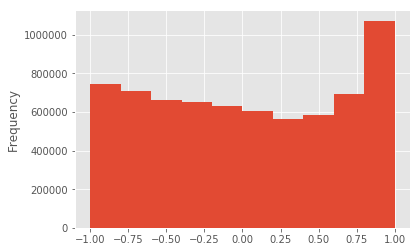

In [464]:
temp.plot(kind='hist')

In [465]:
temp[temp==1].shape

(363,)

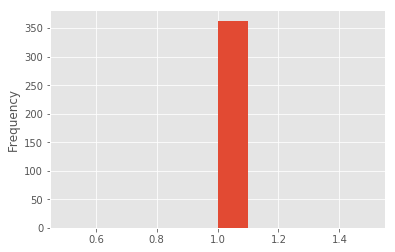

In [466]:
desc_dict = {}
from Bio import SeqIO
for record in SeqIO.parse("in_data/TriTrypDB-37_TbruceiTREU927_AnnotatedProteins.fasta", "fasta"):
    
    #print(record.description)
    if '|' in record.description:
        desc = record.description.split(' | ')[4].split('=')[1].strip()
    else:
        desc = record.description
    
    desc_dict[utilities.clean_id(record.id)]=desc
temp[temp==1].plot(kind='hist')

In [467]:
tempv = temp[temp==1].to_frame()

In [468]:
tempv.columns = ['p']

In [469]:
tempv['d1'] = ['_'.join(desc_dict[n[0]].split(' ')[0:2]).replace(',','') for n in tempv.index.values] 
tempv['d2'] = ['_'.join(desc_dict[n[1]].split(' ')[0:2]).replace(',','') for n in tempv.index.values] 
tempv['p_1'] = [n[0] for n in tempv.index.values]
tempv['p_2'] = [n[1] for n in tempv.index.values]
tempv['id_1'] = tempv['p_1']+'_'+tempv['d1']
tempv['id_2'] = tempv['p_2']+'_'+tempv['d2']
tempv.to_csv('temp_visant.txt',sep='\t')
tempv.tail()

,,p,d1,d2,p_1,p_2,id_1,id_2
prot_id,prot_id,,,,,,,
Tb927.11.3160,Tb927.11.1300,1.0,hypothetical_protein,UBA/TS-N_domain,Tb927.11.3160,Tb927.11.1300,Tb927.11.3160_hypothetical_protein,Tb927.11.1300_UBA/TS-N_domain
Tb927.5.1090,Tb927.9.9860,1.0,threonyl-tRNA_synthetase,170_kDa,Tb927.5.1090,Tb927.9.9860,Tb927.5.1090_threonyl-tRNA_synthetase,Tb927.9.9860_170_kDa
Tb927.11.1840,Tb927.11.1740,1.0,hypothetical_protein,intraflagellar_transport,Tb927.11.1840,Tb927.11.1740,Tb927.11.1840_hypothetical_protein,Tb927.11.1740_intraflagellar_transport
Tb927.11.14190,Tb927.11.4950,1.0,Staphylococcal_nuclease,hypothetical_protein,Tb927.11.14190,Tb927.11.4950,Tb927.11.14190_Staphylococcal_nuclease,Tb927.11.4950_hypothetical_protein
Tb927.2.5660,Tb927.11.10740,1.0,adenylate_kinase,vacuolar_sorting-associated,Tb927.2.5660,Tb927.11.10740,Tb927.2.5660_adenylate_kinase,Tb927.11.10740_vacuolar_sorting-associated


In [272]:
tempv.tail()

,,p,d1,d2,p_1,p_2,id_1,id_2
prot_id,prot_id,,,,,,,
Tb927.4.2240,Tb927.5.550,1.0,Aminotransferase_class,V-type_proton,Tb927.4.2240,Tb927.5.550,Tb927.4.2240_Aminotransferase_class,Tb927.5.550_V-type_proton
Tb927.7.2080,Tb927.7.4990,1.0,cap_guanylyltransferase-methyltransferase,hypothetical_protein,Tb927.7.2080,Tb927.7.4990,Tb927.7.2080_cap_guanylyltransferase-methyltra...,Tb927.7.4990_hypothetical_protein
Tb927.2.6090,Tb927.11.13230,1.0,60S_ribosomal,VAMP-associated_protein,Tb927.2.6090,Tb927.11.13230,Tb927.2.6090_60S_ribosomal,Tb927.11.13230_VAMP-associated_protein
Tb927.8.5090,Tb927.11.630,1.0,DNA-directed_RNA,RNA_polymerase,Tb927.8.5090,Tb927.11.630,Tb927.8.5090_DNA-directed_RNA,Tb927.11.630_RNA_polymerase
Tb927.11.15270,Tb927.10.9810,1.0,phosphopantetheine_adenylyltransferase,hypothetical_protein,Tb927.11.15270,Tb927.10.9810,Tb927.11.15270_phosphopantetheine_adenylyltran...,Tb927.10.9810_hypothetical_protein


In [470]:
import networkx as nx

In [492]:
G = nx.Graph()
G.add_edge(1, 2)
G.add_edge(1, 3)
G.neighbors(1)

[2, 3]

In [493]:
G = nx.Graph()
G.add_edge('Tb927.4.2240', 'Tb927.5.550')
G.add_edge('Tb927.4.2240', 'Tb927.7.4990')
G.neighbors('Tb927.4.2240')

['Tb927.5.550', 'Tb927.7.4990']

In [498]:
G = nx.Graph()
nodes = list(set(list(tempv['p_1'].values)+list(tempv['p_2'].values)))
for a in nodes:
    G.add_node(a, desc=desc_dict[a])
for a, b in zip(tempv['p_1'].values, tempv['p_2'].values):
    G.add_edge(*(a, b))


In [499]:
G.number_of_nodes()

406

In [500]:
 G.number_of_edges()

363

In [501]:
G.neighbors('Tb927.4.2240')

['Tb927.11.3160',
 'Tb927.11.1300',
 'Tb927.1.1270',
 'Tb927.8.5600',
 'Tb927.5.550',
 'Tb927.11.1760']

In [504]:
find_cliques = [n for n in nx.find_cliques(G)]

In [517]:
len(find_cliques)

167

In [506]:
'''

for c in all_clusters['clusters_1.33'].unique()[0:100]:
    parz = []
    prots = set(all_clusters[all_clusters['clusters_1.33']==c].index.values)
    print ('c', c, len(prots))
    for c2 in all_clusters['clusters_0.98'].unique():
        ref = set(all_clusters[all_clusters['clusters_0.98']==c2].index.values)
        if (len(prots&ref)) >1:
            prots2 = prots & ref
            print (c2,  len(prots&ref))
    
   #         for c3 in all_clusters['clusters_1.11'].unique():
   #             ref = set(all_clusters[all_clusters['clusters_1.11']==c2].index.values)
    #            if (len(prots2&ref)) >1:
    #                #prots = prots & ref
    #                print ('c3',  len(prots2&ref)) 
    print ('__________________________end_____________')
    
'''        



    

"\n\nfor c in all_clusters['clusters_1.33'].unique()[0:100]:\n    parz = []\n    prots = set(all_clusters[all_clusters['clusters_1.33']==c].index.values)\n    print ('c', c, len(prots))\n    for c2 in all_clusters['clusters_0.98'].unique():\n        ref = set(all_clusters[all_clusters['clusters_0.98']==c2].index.values)\n        if (len(prots&ref)) >1:\n            prots2 = prots & ref\n            print (c2,  len(prots&ref))\n    \n   #         for c3 in all_clusters['clusters_1.11'].unique():\n   #             ref = set(all_clusters[all_clusters['clusters_1.11']==c2].index.values)\n    #            if (len(prots2&ref)) >1:\n    #                #prots = prots & ref\n    #                print ('c3',  len(prots2&ref)) \n    print ('__________________________end_____________')\n    \n"

In [556]:
gene_table = pd.read_table('gene_table.txt')
gene_table.set_index('[Input ID]',inplace=True)
gene_table.head()
gene_table['[Molecular Weight]']=gene_table['[Molecular Weight]']/1000
gene_table['[Molecular Weight]']=gene_table['[Molecular Weight]'].astype(int)

KeyError: "None of [['Tb927.11.14250', 'Tb927.8.3150', 'Tb927.11.3240', 'Tb927.11.1900']] are in the [index]"

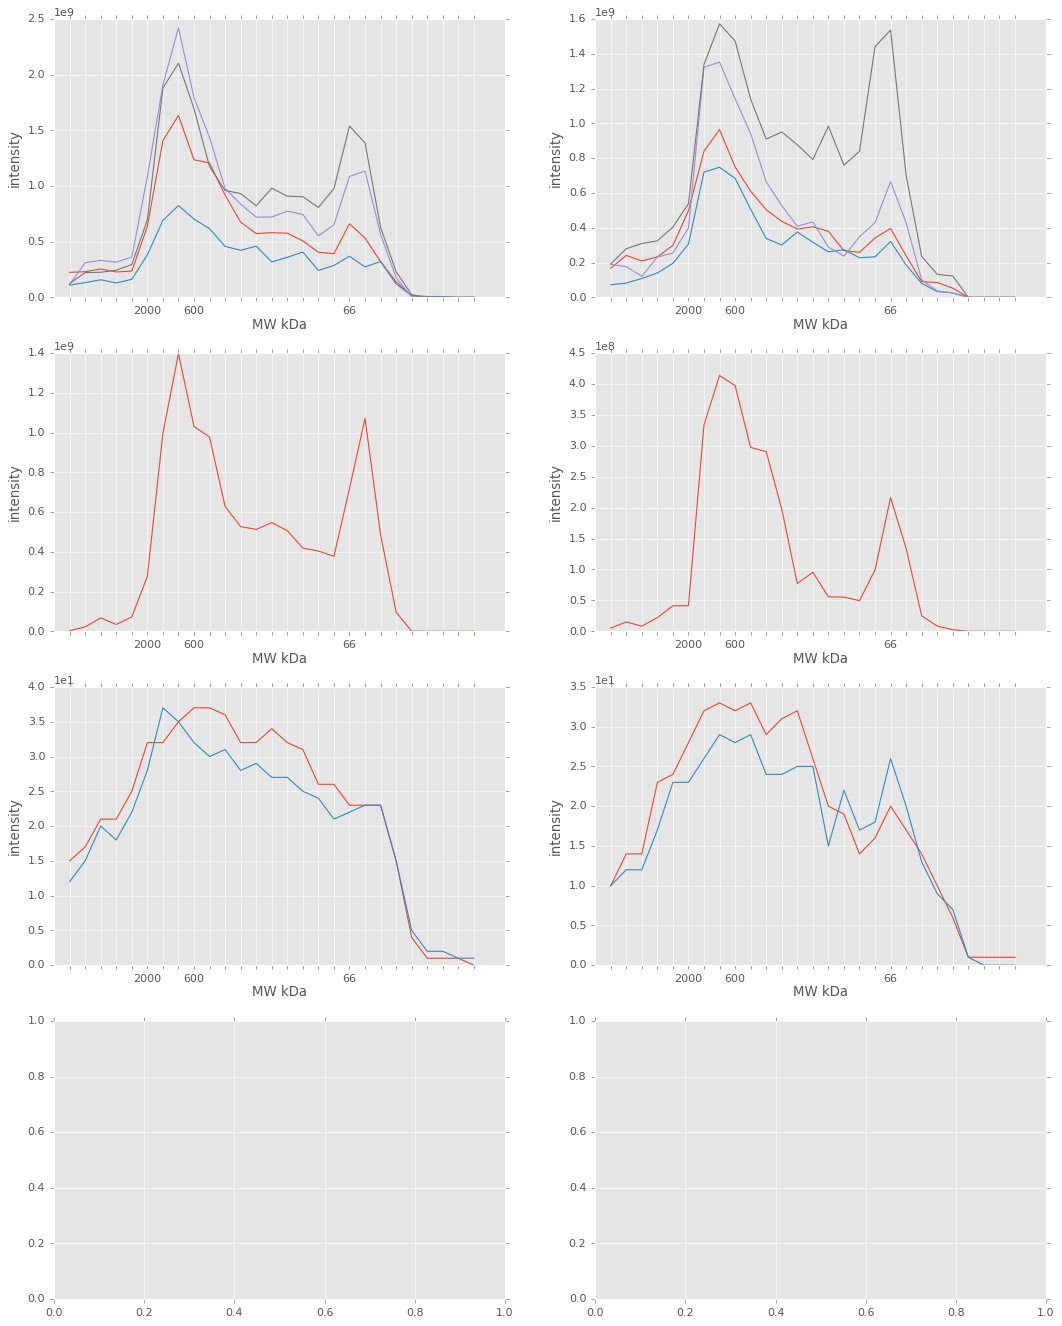

In [771]:
prots = ['Tb927.10.8190',
'Tb927.11.14250',
'Tb927.8.3150',
'Tb927.11.3240',
'Tb927.11.1900']
fig,axes = plt.subplots(ncols=2,nrows=4,figsize=(16,20))
prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][2].loc[prots], axes[0,1])
plot_line(res['ibaq'][0][0].loc[prots], axes[1,0])
plot_line(res['ibaq'][0][2].loc[prots], axes[1,1])
plot_line(res['upep'][0][0].loc[prots], axes[2,0])
plot_line(res['upep'][0][2].loc[prots], axes[2,1])
plot_line(res['msms'][0][0].loc[prots], axes[3,0])
plot_line(res['msms'][0][2].loc[prots], axes[3,1])
plt.legend(bbox_to_anchor=(0.6, -0.3))
axes[0,0].set_title('lfq 1')
axes[0,1].set_title('lfq 3')
axes[1,0].set_title('ibaq 1')
axes[1,1].set_title('ibaq 3')
axes[2,0].set_title('upep 1')
axes[2,1].set_title('upep 3')
axes[3,0].set_title('msms')
axes[3,1].set_title('msms')
#plt.suptitle('Cytoplasmic dynein', fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
gene_table[['[Molecular Weight]','[# TM Domains]','[Product Description]']].loc[prots]

In [735]:
temp = res['lfq'][0][0]
temp.head()

,LFQ intensity 1,LFQ intensity 2,LFQ intensity 3,LFQ intensity 4,LFQ intensity 5,LFQ intensity 6,LFQ intensity 7,LFQ intensity 8,LFQ intensity 9,LFQ intensity 10,...,LFQ intensity 19,LFQ intensity 20,LFQ intensity 21,LFQ intensity 22,LFQ intensity 23,LFQ intensity 24,LFQ intensity 25,LFQ intensity 26,LFQ intensity 27,max
prot_id,,,,,,,,,,,,,,,,,,,,,
Tb927.6.1260,0,0,0,15238000,0,0,0,0,0,46903000,...,75481000,59497000,74272000,101150000,59816000,533800000,76966000,237980000,257490000,23
Tb927.11.6080,0,0,0,0,0,0,4803600,5242600,7262000,7653200,...,0,0,0,0,0,0,0,0,0,9
Tb927.10.12500,406570000,501960000,391420000,351330000,254660000,198470000,243420000,290450000,373090000,474580000,...,3032700000,1625000000,767290000,342200000,64228000,119300000,9744100,37441000,45995000,18
Tb927.3.5320,0,0,3337200,5007400,6862400,7645700,6962600,12507000,9517200,9902100,...,6159700,49341000,89227000,122840000,15788000,0,0,0,0,21
Tb927.7.4490,0,0,0,0,0,8889000,4805300,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [737]:
temp = temp[(temp['max']>5) & (temp['max']<18)]

In [738]:
def norm_mm(X):
    (X-X.min())/(X.max()-X.min())
    return X

In [740]:
del temp['max']

In [741]:
temp = temp.apply(norm_mm, axis=1)
temp = temp

In [742]:
temp.head()

,LFQ intensity 1,LFQ intensity 2,LFQ intensity 3,LFQ intensity 4,LFQ intensity 5,LFQ intensity 6,LFQ intensity 7,LFQ intensity 8,LFQ intensity 9,LFQ intensity 10,...,LFQ intensity 18,LFQ intensity 19,LFQ intensity 20,LFQ intensity 21,LFQ intensity 22,LFQ intensity 23,LFQ intensity 24,LFQ intensity 25,LFQ intensity 26,LFQ intensity 27
prot_id,,,,,,,,,,,,,,,,,,,,,
Tb927.11.6080,0,0,0,0,0,0,4803600,5242600,7262000,7653200,...,0,0,0,0,0,0,0,0,0,0
Tb927.11.630,0,11204000,10995000,36428000,46279000,53182000,106550000,244980000,187980000,247210000,...,0,0,0,0,0,0,0,0,0,0
Tb927.10.12510,161740000,165600000,99941000,124230000,77430000,71663000,47580000,47321000,80529000,131250000,...,1074400000,340740000,434290000,241510000,135160000,0,0,0,0,0
Tb927.1.650,0,0,0,0,0,0,0,0,1778200,0,...,0,0,0,0,0,0,0,0,0,0
Tb927.10.4470,0,0,0,0,0,0,4644600,5992300,5207000,0,...,0,0,0,0,0,0,0,0,0,0


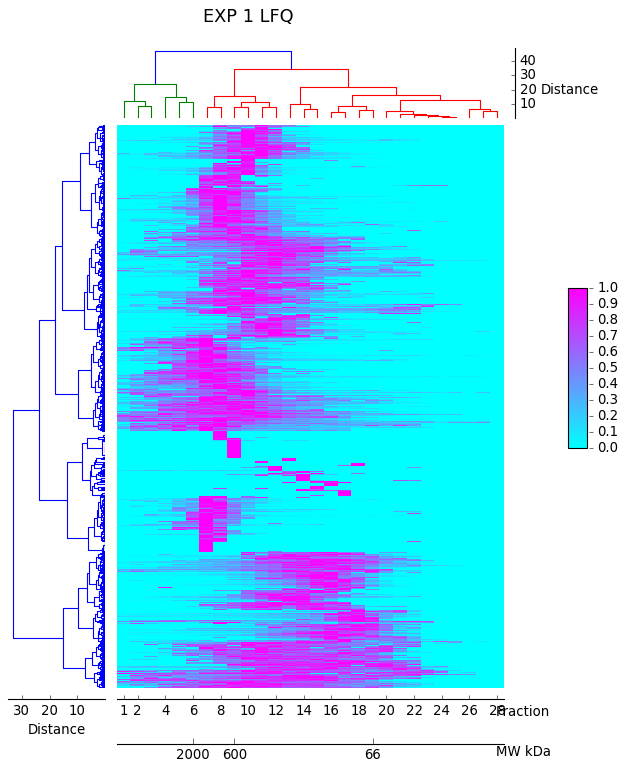

In [744]:
from scripts import make_fig
from scripts import utilities
import warnings
warnings.filterwarnings("ignore")
#create the plot
cluster_df, leaves = make_fig.plot_experiment(
     temp.apply(utilities.norm_max,1),
     method='ward', 
     metric='euclidean',
     cluster_columns = True,
     order_row_and_columns= False,
     color_map_id='cool',
     figsize=(8, 10),
     cut_distance_cols=40,
     cut_distance_rows=0.1,
     step_first_x = 2,
     title='EXP 1 LFQ',
     fig_name = 'EXP 1 LFQ.png',
     add_second_axis={'label':'MW kDa',
                      'values': {
                      6:'2000', 
                      9:'600', 
                      #4:'132', 
                      19:'66', 
                      } 
                      },
    height_ratios=[1, 8],
    hspace=0.02,
    get_clusters=True,
    owerwrite_order=False,
     )


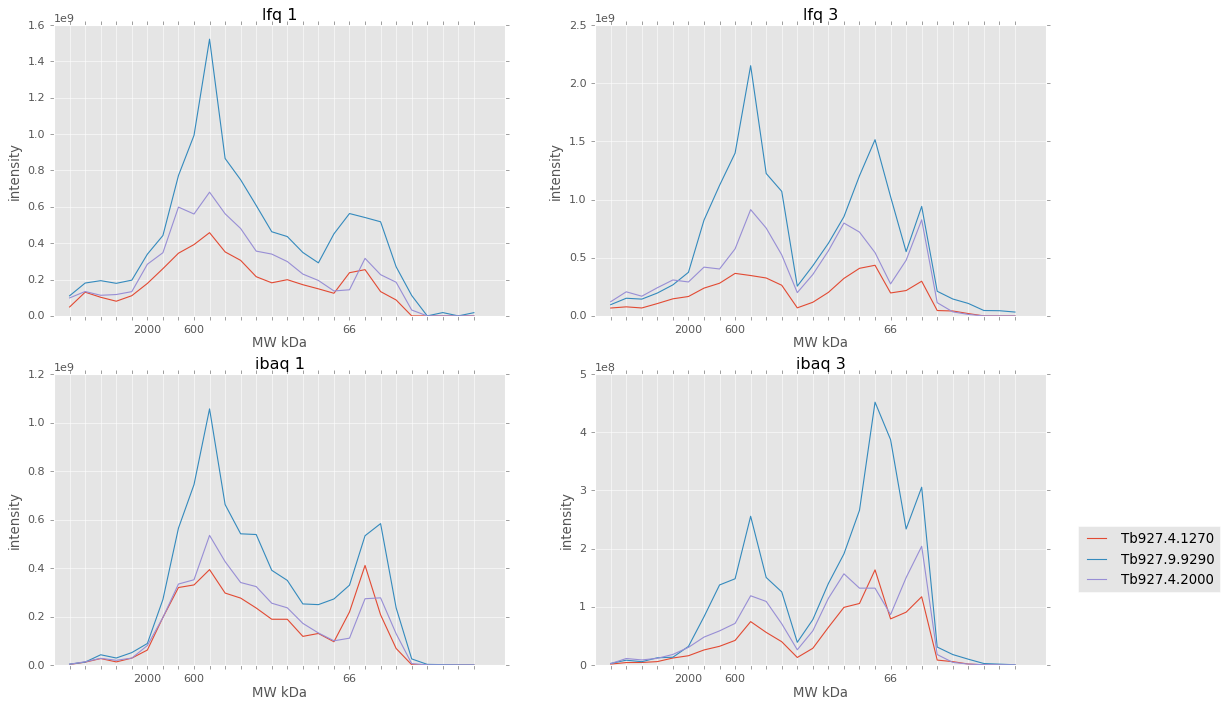

              [Molecular Weight]  [# TM Domains]  \
[Input ID]                                         
Tb927.4.1270                  49               0   
Tb927.9.9290                  63               0   
Tb927.4.2000                  52               0   

                         [Product Description]  
[Input ID]                                      
Tb927.4.1270  ruvB-like DNA helicase, putative  
Tb927.9.9290   polyadenylate-binding protein 1  
Tb927.4.2000  ruvB-like DNA helicase, putative  


In [775]:
prots=['Tb927.4.1270',
'Tb927.9.9290',
'Tb927.4.2000']
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(16,10))
prots = [n  for n in prots if n in res['lfq'][0][0].index.values]
plot_line(res['lfq'][0][0].loc[prots], axes[0,0])
plot_line(res['lfq'][0][1].loc[prots], axes[0,1])
plot_line(res['ibaq'][0][0].loc[prots], axes[1,0])
plot_line(res['ibaq'][0][1].loc[prots], axes[1,1])
plt.legend(bbox_to_anchor=(1.4, 0.5))
axes[0,0].set_title('lfq 1')
axes[0,1].set_title('lfq 3')
axes[1,0].set_title('ibaq 1')
axes[1,1].set_title('ibaq 3')
#plt.suptitle('Cytoplasmic dynein', fontsize=21)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
print(gene_table[['[Molecular Weight]','[# TM Domains]','[Product Description]']].loc[prots])


In [ ]:
#counting the outputs
def reduce_res(res_path, outname):
    list_df = [pd.read_table(os.path.join(res_path, file_name),
                             sep='\t') for file_name in os.listdir(res_path)]
    if len(list_df)>0:
        list_df = pd.concat(list_df)
        list_df.sort_values(by='cut_distance', ascending=True, inplace=True)
        print (list_df.head())
        combined = list_df.groupby('cut_distance').sum()
        del combined['cluster_id']
        print (combined.head())
        combined.to_csv(outname)
                
for q in ['lfq', 'ibaq']:
    for exp in [0,1]:
        path = 'D:/git/fernando/final_run/go_results/'        
        reduce_res(path+q+'_'+str(exp), path+q+'_'+str(exp)+'_reduced_go_terms.csv')